In [2]:
import os
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
filename = 'N-CMAPSS_DS02-006.h5'

In [4]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.007474999999999998

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [6]:
print("dev_engines:", np.unique(A_dev[:, 0]))
print("test_engines:",np.unique(A_test[:, 0]))

dev_engines: [ 2.  5. 10. 16. 18. 20.]
test_engines: [11. 14. 15.]


In [7]:
state = A_dev[:, 3]                  
units_serial = [2, 5, 10] # engine serial
num_units = len(units_serial)
change_idx_one = np.where((state[:-1] == 1) & (state[1:] == 0))[0]
change_idx_two = np.where((state[:-1] == 0) & (state[1:] == 1))[0]
change_idx_one = np.sort(change_idx_one)
change_idx_two = np.sort(change_idx_two)

normal_ranges = []
if len(change_idx_one) > 0:
    normal_ranges.append((0, change_idx_one[0]))
for i in range(len(change_idx_two)):
    if i + 1 < len(change_idx_one):
        start = change_idx_two[i]
        end   = change_idx_one[i + 1]
        if start < end:
            normal_ranges.append((start, end))

print("A_dev normal ranges:", normal_ranges)

samples_per_range = 50
random_indices_list = []   # list to store selected indices for each range

for (start, end) in normal_ranges:
    # create an array of all indices within the range
    idx_range = np.arange(start, end + 1)

    # if the range has at least 50 samples, randomly choose 50 without replacement
    if len(idx_range) >= samples_per_range:
        selected = np.random.choice(idx_range, size=samples_per_range, replace=False)
    else:
        # if less than 50 samples available, take all of them
        selected = idx_range.copy()

    random_indices_list.append(selected)

A_dev normal ranges: [(0, np.int64(188862)), (np.int64(853141), np.int64(1041691)), (np.int64(1886561), np.int64(2074611)), (np.int64(2839272), np.int64(3033891)), (np.int64(3604567), np.int64(3797856)), (np.int64(4495286), np.int64(4688640))]


In [22]:
N = 300
all_idx = np.concatenate(random_indices_list, axis=0)
all_idx = np.unique(all_idx)
selected_indices = np.random.choice(all_idx, size=N, replace=False)
selected_indices = np.sort(selected_indices)
selected_indices_copy = np.sort(selected_indices)
sampled_dev_idx = selected_indices

T_test = X_s_test.shape[0]

# every single engine has 100 indices individually
K = 250  # 엔진당 100개
eng = A_test[:, 0].astype(int)

# 엔진 구간 시작/끝 찾기 (연속 블록 가정)
change = np.nonzero(eng[1:] != eng[:-1])[0] + 1
starts = np.r_[0, change]
ends   = np.r_[change, len(eng)]

sampled_test_idx_list = []
for s, e in zip(starts, ends):
    T_e = e - s
    if T_e <= 0:
        continue

    k = min(K, T_e)
    pos = np.linspace(0, T_e - 1, num=k)
    pos = np.round(pos).astype(int)

    # 반올림 중복 보정(필요 시)
    pos = np.unique(pos)
    if pos.size < k:
        pool = np.setdiff1d(np.arange(T_e), pos)
        need = k - pos.size
        add = np.linspace(0, pool.size - 1, num=need)
        add = np.round(add).astype(int)
        pos = np.sort(np.concatenate([pos, pool[add]]))
    else:
        pos = np.sort(pos[:k])

    sampled_test_idx_list.append((s + pos))

sampled_test_idx = np.sort(np.concatenate(sampled_test_idx_list))

# sampled_test_idx = np.random.choice(T_test, size=N, replace=False)
# sampled_test_idx = np.sort(sampled_test_idx)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

selected_indices = [torch.tensor(sampled_dev_idx, device=device)]
selected_indices_test = [torch.tensor(sampled_test_idx, device=device)]

X_list = [torch.tensor(W_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
Y_list = [torch.tensor(X_s_dev[idx.cpu().numpy()], dtype=torch.float32).to(device)
          for idx in selected_indices]
x_test_list = [torch.tensor(W_test[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]
y_test_list = [torch.tensor(X_s_test[idx.cpu().numpy()], dtype=torch.float32).to(device)
               for idx in selected_indices_test]

X = torch.cat(X_list, dim=0)        # (N_dev, D)
Y = torch.cat(Y_list, dim=0)        # (N_dev, 14)
x_test = torch.cat(x_test_list, dim=0)   # (N_test, D)
y_test = torch.cat(y_test_list, dim=0)   # (N_test, 14)

x_mean = X.mean(dim=0)
x_var  = X.var(dim=0, unbiased=False)
x_std  = x_var.sqrt()
x_scaled = (X - x_mean) / x_std

y_mean = Y.mean(dim=0)              # (14,)
y_var  = Y.var(dim=0, unbiased=False)
y_std  = y_var.sqrt()               # (14,)
y_scaled = (Y - y_mean) / y_std     # (N_dev, 14)

[INFO] common sampled_idx len = 1000

=== [0] T24 ===
[Value]
MAE  : 0.0109
RMSE : 0.0169
R²   : 0.9997

=== [1] T30 ===
[Value]
MAE  : 0.0118
RMSE : 0.0172
R²   : 0.9998

=== [2] T48 ===
[Value]
MAE  : 0.0565
RMSE : 0.0945
R²   : 0.9925

=== [3] T50 ===
[Value]
MAE  : 0.0943
RMSE : 0.1587
R²   : 0.9798

=== [4] P15 ===
[Value]
MAE  : 0.0021
RMSE : 0.0029
R²   : 1.0000

=== [5] P2 ===
[Value]
MAE  : 0.0016
RMSE : 0.0026
R²   : 1.0000

=== [6] P21 ===
[Value]
MAE  : 0.0022
RMSE : 0.0033
R²   : 1.0000

=== [7] P24 ===
[Value]
MAE  : 0.0052
RMSE : 0.0079
R²   : 0.9999

=== [8] Ps30 ===
[Value]
MAE  : 0.0090
RMSE : 0.0133
R²   : 0.9999

=== [9] P40 ===
[Value]
MAE  : 0.0099
RMSE : 0.0148
R²   : 0.9998

=== [10] P50 ===
[Value]
MAE  : 0.0026
RMSE : 0.0040
R²   : 1.0000

=== [11] Nf ===
[Value]
MAE  : 0.0036
RMSE : 0.0057
R²   : 1.0000

=== [12] Nc ===
[Value]
MAE  : 0.0225
RMSE : 0.0361
R²   : 0.9989

=== [13] Wf ===
[Value]
MAE  : 0.0153
RMSE : 0.0240
R²   : 0.9996


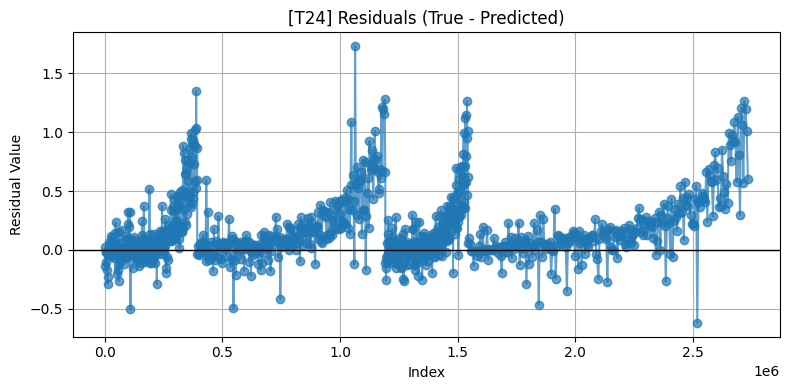

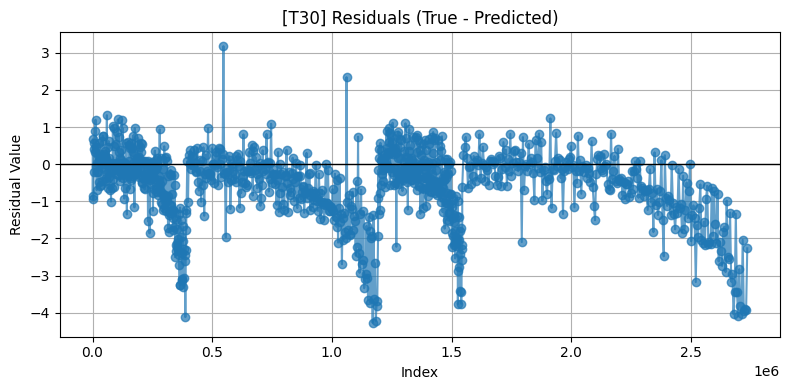

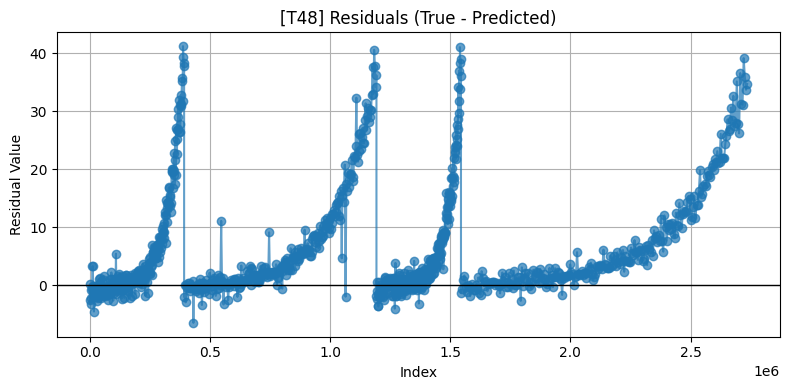

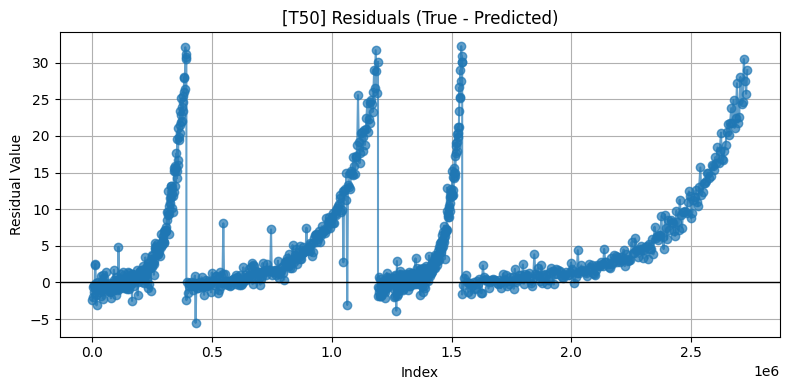

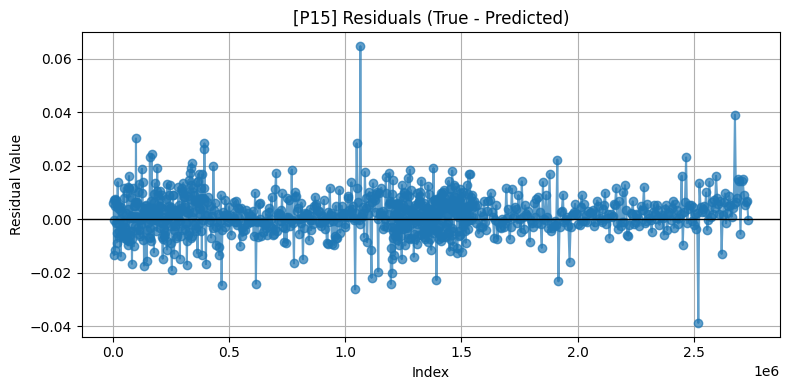

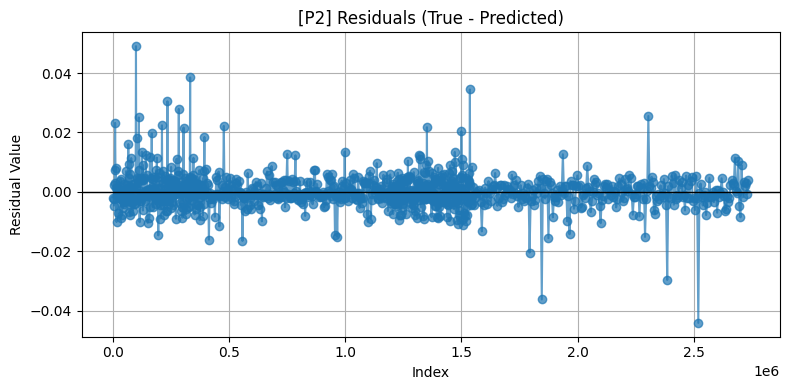

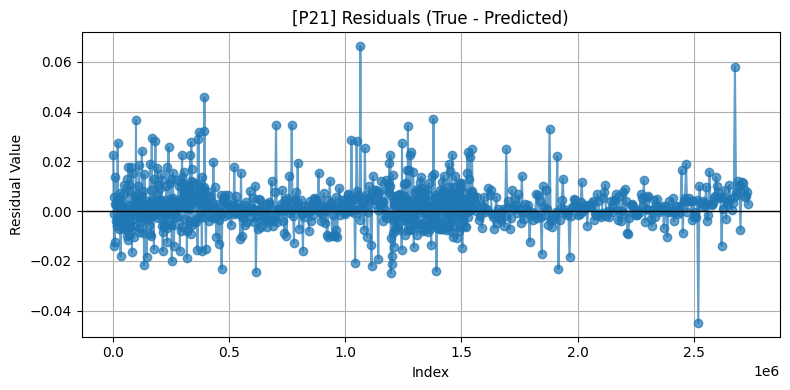

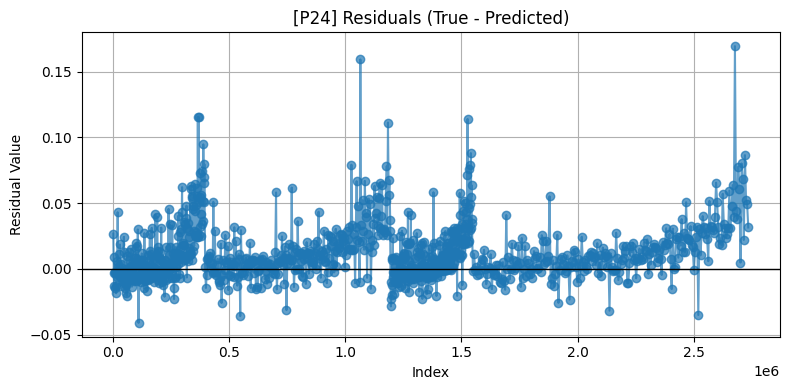

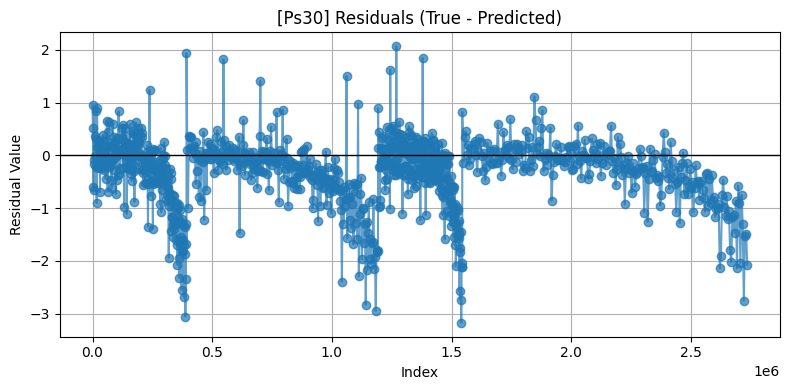

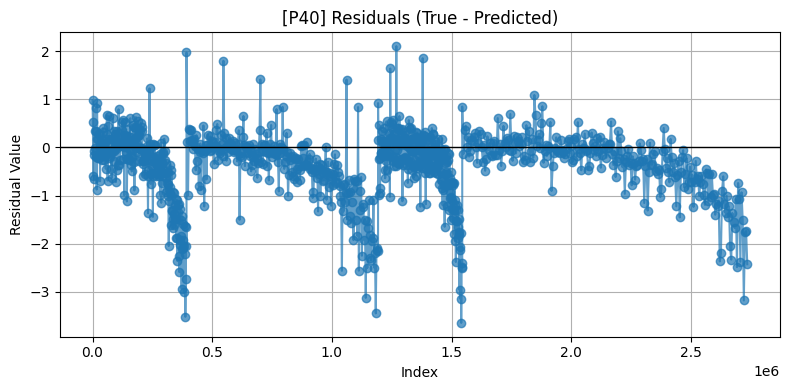

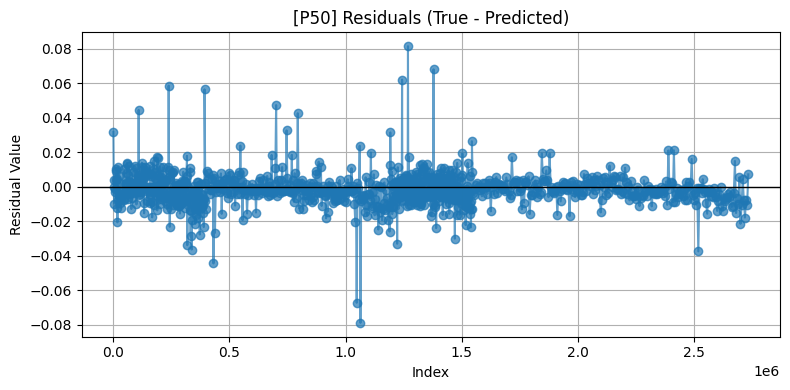

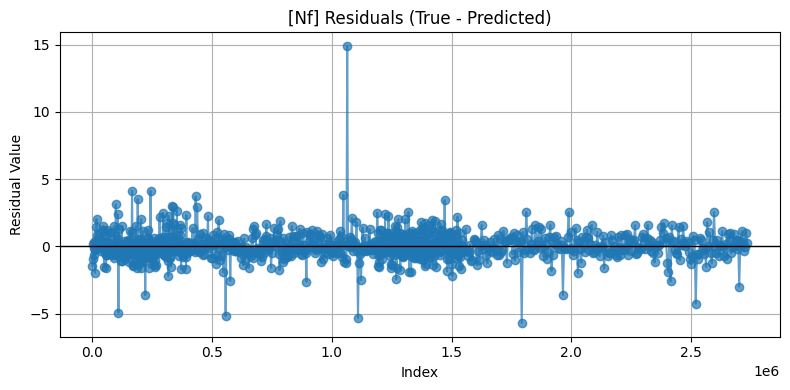

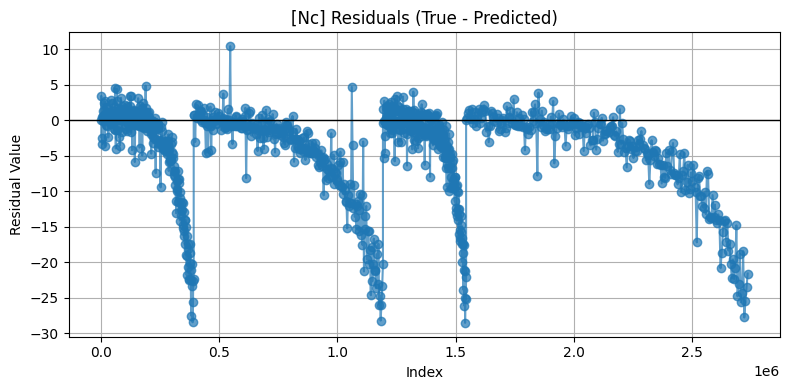

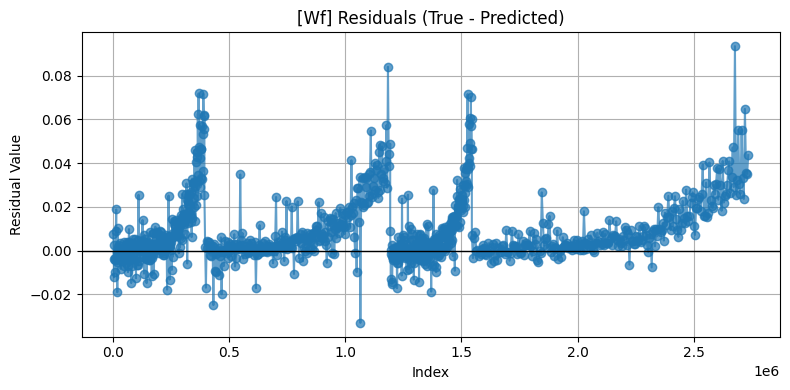

In [8]:
import gpytorch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

output_names = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24',
                'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']

# 0) 잔차 저장용
all_residuals = []
high_r2_list = []
total_all_idx = sampled_test_idx

sampled_idx = sampled_test_idx
# N_sel = min(N, len(total_all_idx))
# sampled_idx = np.random.choice(total_all_idx, size=N_sel, replace=False)
# sampled_idx.sort()
print(f"[INFO] common sampled_idx len = {len(sampled_idx)}")

# =========================================================
# 1) 다출력 GP 모델 정의
# =========================================================
num_tasks = Y.shape[1]   # 14

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # 각 task별 상수 평균 + multitask 구조
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        # 입력 커널(RBF) × task 간 공분산(coregionalization)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(),
            num_tasks=num_tasks,
            rank=2,   # task 공분산 rank (필요시 조정)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)       # (N, num_tasks)
        covar_x = self.covar_module(x)     # Multitask 커널
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# 학습 데이터
train_x = x_scaled.to(device)      # (N_dev, D)
train_y = y_scaled.to(device)      # (N_dev, 14)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=num_tasks
).to(device)

model = MultitaskGPModel(train_x, train_y, likelihood).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# =========================================================
# 2) train (한 번만)
# =========================================================
model.train(); likelihood.train()
num_iters = 100
for i in range(num_iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # 필요하면 loss 출력
    # if (i+1) % 10 == 0:
    #     print(f"Iter {i+1}/{num_iters}, loss={loss.item():.4f}")

# =========================================================
# 3) TEST 전체에 대한 다출력 예측 + 지표
# =========================================================
model.eval(); likelihood.eval()

x_test_scaled = (x_test - x_mean) / x_std
x_test_scaled = x_test_scaled.to(device)

y_test_scaled = (y_test - y_mean) / y_std     # (N_test, 14)
y_test_scaled_t = y_test_scaled.to(device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(x_test_scaled))
    mean_all = preds.mean    # (N_test, 14)

# 출력별 지표 계산
for j, name in enumerate(output_names):
    y_true_j = y_test_scaled_t[:, j].cpu().numpy()
    y_pred_j = mean_all[:, j].cpu().numpy()

    mse  = mean_squared_error(y_true_j, y_pred_j)
    mae  = mean_absolute_error(y_true_j, y_pred_j)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_j, y_pred_j)
    high_r2_list.append({
        "name": name,
        "r2": r2,
    })

    print(f"\n=== [{j}] {name} ===")
    print(f"[Value]")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

# =========================================================
# 4) 공통 인덱스(sampled_idx)에서 잔차 (실제 - 예측) 저장
# =========================================================
# 4-1) 공통 인덱스의 입력
x_sel = torch.tensor(W_test[sampled_idx], dtype=torch.float32, device=device)
x_sel_scaled = (x_sel - x_mean) / x_std

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_sel = likelihood(model(x_sel_scaled))
    mean_sel_all = preds_sel.mean          # (N_sel, 14)

# 4-2) 출력별 잔차 계산 (언스케일)
for j, name in enumerate(output_names):
    # 실제값 (원 스케일)
    y_true_unscaled = torch.tensor(
        X_s_test[sampled_idx, j],
        dtype=torch.float32,
        device=device
    )

    # 예측값 (원 스케일로 되돌리기)
    y_pred_unscaled = mean_sel_all[:, j] * y_std[j] + y_mean[j]

    residual = (y_true_unscaled - y_pred_unscaled).detach().cpu().numpy()

    all_residuals.append({
        "name": name,
        "idx": sampled_idx.copy(),
        "residual": residual.copy(),
    })
    # print(f"[STORE] {name} residual saved. N={len(residual)}")
    plt.figure(figsize=(8,4))
    plt.plot(sampled_idx, residual, marker='o', linestyle='-', alpha=0.7)
    plt.axhline(0, color='black', linewidth=1)         # baseline
    plt.title(f"[{name}] Residuals (True - Predicted)")
    plt.xlabel("Index")
    plt.ylabel("Residual Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
print("len(all_residuals) =", len(all_residuals))

# 각 변수별 residual/idx 길이 확인
for i, d in enumerate(all_residuals):
    print(f"[{i:02d}] {d['name']}: len(idx)={len(d['idx'])}, len(residual)={len(d['residual'])}")

# (선택) 길이가 서로 다른지 요약
lens = [len(d["residual"]) for d in all_residuals]
print("unique residual lengths =", sorted(set(lens)))

len(all_residuals) = 14
[00] T24: len(idx)=1000, len(residual)=1000
[01] T30: len(idx)=1000, len(residual)=1000
[02] T48: len(idx)=1000, len(residual)=1000
[03] T50: len(idx)=1000, len(residual)=1000
[04] P15: len(idx)=1000, len(residual)=1000
[05] P2: len(idx)=1000, len(residual)=1000
[06] P21: len(idx)=1000, len(residual)=1000
[07] P24: len(idx)=1000, len(residual)=1000
[08] Ps30: len(idx)=1000, len(residual)=1000
[09] P40: len(idx)=1000, len(residual)=1000
[10] P50: len(idx)=1000, len(residual)=1000
[11] Nf: len(idx)=1000, len(residual)=1000
[12] Nc: len(idx)=1000, len(residual)=1000
[13] Wf: len(idx)=1000, len(residual)=1000
unique residual lengths = [1000]


In [10]:
high_r2_list_sorted = sorted(high_r2_list, key=lambda d: d["r2"])

# R^2 오름차순 정렬(낮은 R^2가 앞)
high_r2_list_sorted = sorted(high_r2_list, key=lambda d: d["r2"])

# (2) R^2 최소값 3개만 남기기
high_r2_list_3 = high_r2_list_sorted[:3] if len(high_r2_list_sorted) >= 3 else high_r2_list_sorted


# (3) hi_var_names 만들기 (원하신 형태)
hi_var_names = [d["name"] for d in high_r2_list_3]
print(hi_var_names)

['T50', 'T48', 'Nc']


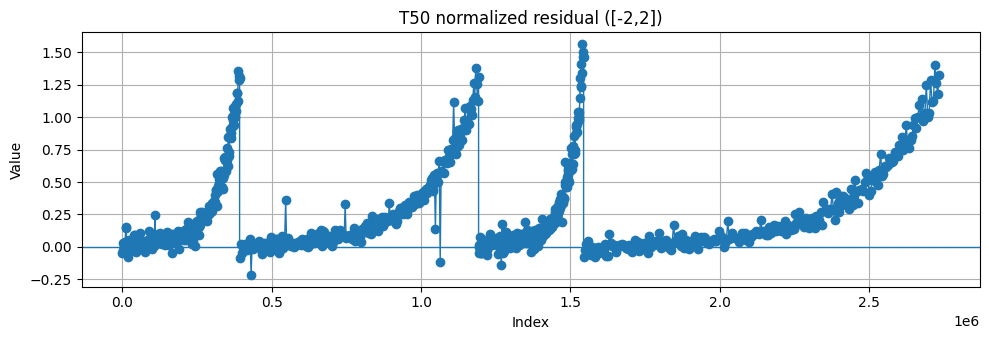

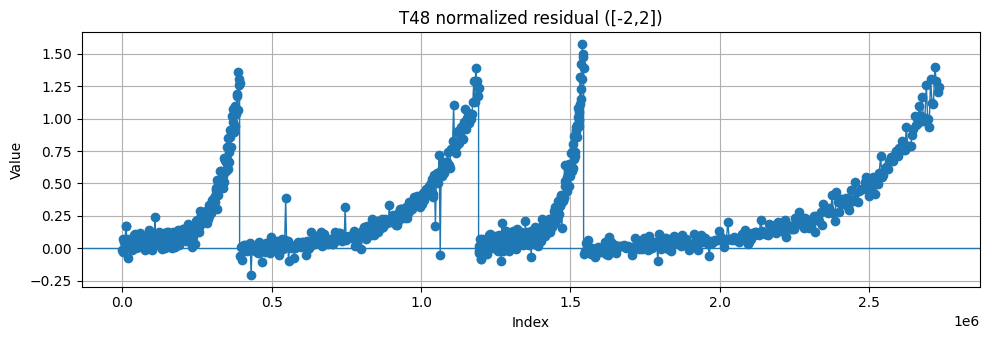

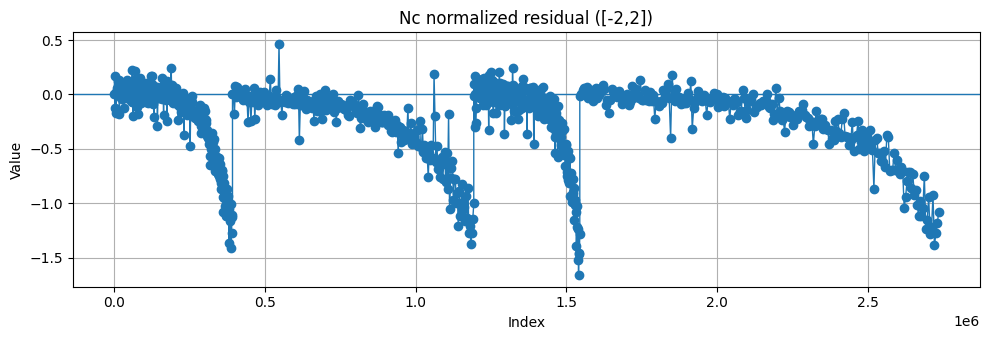

In [11]:
import numpy as np

def build_all_residuals_enginewise_01pm(
    all_residuals,
    hi_var_names,
    A_test,
    engine_col=0,
    time_col=1,
    k0=5,                 # 시작 baseline 구간 길이
    scale="p95",          # "p95" or "max"
    clip=1.0,
    eps=1e-12,
):
    """
    엔진별 정규화:
      - baseline = median(first k0 points)
      - centered = r - baseline  (시작을 0 근처로)
      - scale = percentile(|centered|,95) 또는 max(|centered|)
      - normalized = clip(centered / scale, -1, 1)

    반환: all_residuals_norm (원본과 동일한 idx 정렬 유지, residual만 교체)
    """
    name2 = {d["name"]: d for d in all_residuals}

    # 엔진 구간(연속 블록 가정이 아니라도 동작하도록 일반형)
    eng = A_test[:, engine_col].astype(int)
    engine_ids = np.unique(eng)

    all_residuals_norm = []

    for name in hi_var_names:
        if name not in name2:
            raise KeyError(f"{name} not found in all_residuals")

        idx = np.asarray(name2[name]["idx"], dtype=np.int64)
        res = np.asarray(name2[name]["residual"], dtype=np.float32)

        # idx -> residual 맵
        res_map = dict(zip(idx.tolist(), res.tolist()))
        idx_set = set(idx.tolist())

        # 정규화된 값 저장용
        norm_map = {}

        for eid in engine_ids:
            # 해당 엔진의 전체 인덱스
            idx_e_all = np.where(eng == eid)[0]

            # all_residuals에 실제로 존재하는 인덱스만 추림
            idx_e = [i for i in idx_e_all.tolist() if i in idx_set]
            if len(idx_e) < max(3, k0):  # 너무 짧으면 스킵
                continue

            # 시간 정렬 (연속/정렬 보장이어도 안전)
            if time_col is not None and A_test.shape[1] > time_col:
                t = A_test[np.array(idx_e), time_col].astype(float)
                idx_e = np.array(idx_e)[np.argsort(t)].tolist()
            else:
                idx_e = sorted(idx_e)

            r = np.array([res_map[int(i)] for i in idx_e], dtype=np.float32)

            # 1) baseline: 시작 k0의 중앙값으로 0 맞추기
            k0_eff = min(k0, len(r))
            baseline = np.median(r[:k0_eff])
            c = r - baseline  # 시작이 0 근처

            # 2) scale: 엔진 내부 변화폭으로 [-1,1] 맞추기
            if scale == "p95":
                s = np.percentile(np.abs(c), 95)
            elif scale == "max":
                s = float(np.max(np.abs(c)))
            else:
                raise ValueError("scale must be 'p95' or 'max'")

            s = max(float(s), eps)
            u = c / s

            # [-clip, clip]로 제한 (clip=1.0이면 [-1,1])
            if clip is not None:
                u = np.clip(u, -clip, clip)

            # 저장
            for ii, uu in zip(idx_e, u.tolist()):
                norm_map[int(ii)] = float(uu)

        # 원본 idx 순서대로 정규화 residual 생성
        # (정규화 못한 인덱스는 NaN으로 둘 수도 있고, 원본 유지할 수도 있음)
        res_norm = np.array([norm_map.get(int(i), np.nan) for i in idx], dtype=np.float32)

        all_residuals_norm.append({
            "name": name,
            "idx": idx.copy(),
            "residual": res_norm,
        })

    return all_residuals_norm
    
all_residuals_norm = build_all_residuals_enginewise_01pm(
    all_residuals=all_residuals,
    hi_var_names=hi_var_names,
    A_test=A_test,
    engine_col=0,
    time_col=1,
    k0=5,
    scale="p95",   # outlier 있으면 p95 권장
    clip=2.0
)

name2 = {d["name"]: d for d in all_residuals_norm}

# 공통 idx
idx_sets = [set(np.asarray(name2[n]["idx"], dtype=np.int64)) for n in hi_var_names]
idx_hi = np.array(sorted(set.intersection(*idx_sets)), dtype=np.int64)

for name in hi_var_names:
    m = dict(zip(np.asarray(name2[name]["idx"], dtype=np.int64),
                 np.asarray(name2[name]["residual"], dtype=np.float32)))

    y = np.array([m[int(i)] for i in idx_hi], dtype=np.float32)

    plt.figure(figsize=(10, 3.5))
    plt.plot(idx_hi, y, marker='o', linestyle='-', linewidth=1)
    plt.axhline(0, linewidth=1)
    plt.title(f"{name} normalized residual ([-2,2])")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
import numpy as np
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import Dict, List, Any, Optional, Tuple


# ============================================================
# 0) Diagnostics (첫 번째 코드 유지)
# ============================================================
@torch.no_grad()
def _lag_diagnostics(h, lag, c_mono, tau):
    h = h.reshape(-1)
    T = h.numel()

    d1 = h[1:] - h[:-1]                       # 1-step slope
    d1_min = float(d1.min().item()) if d1.numel() else 0.0
    d1_max = float(d1.max().item()) if d1.numel() else 0.0
    d1_neg_cnt = int((d1 < 0).sum().item()) if d1.numel() else 0
    d1_pos_cnt = int((d1 > 0).sum().item()) if d1.numel() else 0
    d1_max_pos = int(torch.argmax(d1).item() + 1) if d1.numel() else -1
    d1_min_pos = int(torch.argmin(d1).item() + 1) if d1.numel() else -1

    dd1 = d1[1:] - d1[:-1]                    # curvature proxy
    dd1_max = float(dd1.max().item()) if dd1.numel() else 0.0
    dd1_min = float(dd1.min().item()) if dd1.numel() else 0.0
    dd1_max_pos = int(torch.argmax(dd1).item() + 2) if dd1.numel() else -1
    dd1_min_pos = int(torch.argmin(dd1).item() + 2) if dd1.numel() else -1

    # lag-step monotone violations
    mono_vio_cnt = 0
    mono_worst = 0.0
    mono_worst_pos = -1
    if T > lag:
        v_mono = (h[:-lag] + c_mono - tau) - h[lag:]   # >0 violation
        mono_vio_cnt = int((v_mono > 0).sum().item())
        if v_mono.numel():
            mono_worst = float(v_mono.max().item())
            mono_worst_pos = int(torch.argmax(v_mono).item() + lag)

    return {
        "T": int(T),
        "h_min": float(h.min().item()),
        "h_max": float(h.max().item()),
        "h_std": float(h.std().item()),
        "h0": float(h[0].item()),
        "hT": float(h[-1].item()),
        "span": float((h[-1] - h[0]).item()),
        "d1_min": d1_min, "d1_min_pos": d1_min_pos,
        "d1_max": d1_max, "d1_max_pos": d1_max_pos,
        "d1_neg_cnt": d1_neg_cnt, "d1_pos_cnt": d1_pos_cnt,
        "dd1_min": dd1_min, "dd1_min_pos": dd1_min_pos,
        "dd1_max": dd1_max, "dd1_max_pos": dd1_max_pos,
        "mono_vio_cnt": mono_vio_cnt,
        "mono_worst": mono_worst,
        "mono_worst_pos": mono_worst_pos,
    }


# ============================================================
# 1) MLP (두 코드 공통이지만 첫 번째 기준 유지)
# ============================================================
class HI_MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        super().__init__()
        dims = [input_dim] + hidden_dims + [1]
        layers = []
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(dims[-2], dims[-1]))  # linear output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # (N,1)


# ============================================================
# 2) Penalty helper (두 번째 코드의 hinge^2 옵션만 "추가"로 통합)
#    기본값은 첫 번째 코드의 exp penalty 유지
# ============================================================
def _penalty(v: torch.Tensor, penalty_kind: str) -> torch.Tensor:
    if v.numel() == 0:
        return torch.tensor(0.0, device=v.device)
    if penalty_kind == "exp":
        return torch.relu(torch.exp(v) - 1.0).mean()
    if penalty_kind == "hinge2":
        return torch.relu(v).pow(2).mean()
    raise ValueError(f"Unknown penalty_kind: {penalty_kind}")


# ============================================================
# 3) Shape-constrained loss (첫 번째 코드 유지 + 두 번째 코드 기능 "옵션 추가")
#    - 첫 번째의 기본 동작: lag 단조, lag 볼록, h(T)=1, span_min
#    - 추가 기능:
#      (B1) multi_lag=True면 k=1..lag 단조/볼록 제약(두 번째 코드 기능)
#      (B2) lambda_smooth>0이면 급상승(양의 곡률 과대) 억제 term_smooth(두 번째 코드 기능)
#      (B3) penalty_kind="hinge2" 지원(두 번째 코드 스타일)
# ============================================================
def shape_constrained_loss_A(
    h: torch.Tensor,
    lambda1: float = 2.7,
    lambda2: float = 4.2,
    lag: int = 5,
    c_mono: float = 0.002,     # strict margin
    w_fail: float = 1.0,       # h(T)=1
    span_min: float = 0.6,     # 붕괴 방지
    w_span: float = 10.0,
    # ---- 추가 옵션(기본은 첫 번째 동작 유지) ----
    multi_lag: bool = False,           # True면 k=1..lag 전부 제약
    penalty_kind: str = "exp",         # "exp"(첫 번째) / "hinge2"(두 번째)
    lambda_smooth: float = 0.0,        # 0이면 비활성
    a_max: float = 0.05,               # sec > a_max 벌점
):
    h = h.reshape(-1)
    T = h.numel()
    device = h.device

    # fail term: h(T)=1
    term_fail = (h[-1] - 1.0) ** 2

    # monotone
    term_mono = torch.tensor(0.0, device=device)
    if T > 1:
        if multi_lag:
            terms = []
            max_k = min(lag, T - 1)
            for k in range(1, max_k + 1):
                v_mono = (h[:-k] + c_mono) - h[k:]
                terms.append(_penalty(v_mono, penalty_kind))
            term_mono = torch.stack(terms).mean() if terms else torch.tensor(0.0, device=device)
        else:
            if T > lag:
                v_mono = (h[:-lag] + c_mono) - h[lag:]
                term_mono = _penalty(v_mono, penalty_kind)

    # convex (Δ² >= 0)
    term_conv = torch.tensor(0.0, device=device)
    if T >= 3:
        if multi_lag:
            terms = []
            max_k = min(lag, (T - 1) // 2)
            for k in range(1, max_k + 1):
                sec = h[2 * k:] - 2.0 * h[k:-k] + h[:-2 * k]
                v_conv = -sec
                terms.append(_penalty(v_conv, penalty_kind))
            term_conv = torch.stack(terms).mean() if terms else torch.tensor(0.0, device=device)
        else:
            if T > 2 * lag:
                sec = h[2 * lag:] - 2.0 * h[lag:-lag] + h[:-2 * lag]
                v_conv = -sec
                term_conv = _penalty(v_conv, penalty_kind)

    # smoothness: sec 너무 큰 양의 곡률만 억제 (두 번째 코드 기능)
    term_smooth = torch.tensor(0.0, device=device)
    if lambda_smooth > 0.0 and T >= 3:
        terms = []
        if multi_lag:
            max_k = min(lag, (T - 1) // 2)
            for k in range(1, max_k + 1):
                sec = h[2 * k:] - 2.0 * h[k:-k] + h[:-2 * k]
                v_smooth = sec - a_max
                terms.append(torch.relu(v_smooth).pow(2).mean())
        else:
            if T > 2 * lag:
                sec = h[2 * lag:] - 2.0 * h[lag:-lag] + h[:-2 * lag]
                v_smooth = sec - a_max
                terms.append(torch.relu(v_smooth).pow(2).mean())
        term_smooth = torch.stack(terms).mean() if terms else torch.tensor(0.0, device=device)

    # span 최소치(상수해 붕괴 방지)
    span = h[-1] - h[0]
    term_span = torch.relu(span_min - span) ** 2

    total = (
        w_fail * term_fail +
        lambda1 * term_mono +
        lambda2 * term_conv +
        w_span * term_span +
        lambda_smooth * term_smooth
    )
    return total, term_fail, term_mono, term_conv, term_span, term_smooth, span


# ============================================================
# 4) Build engine sequences (첫 번째 코드 유지: residual_mode 지원)
# ============================================================
def build_engine_sequences_from_residuals(
    all_residuals,
    hi_var_names,
    A_test,
    engine_col=0,
    time_col=1,
    residual_mode="raw",  # "raw" | "abs" | "square"
):
    print("\n[DEBUG] Build engine sequences")

    name2data = {d["name"]: d for d in all_residuals}
    sequences = {}

    var_idx = {}
    var_res = {}

    for name in hi_var_names:
        idx = np.asarray(name2data[name]["idx"], dtype=np.int64)
        res = np.asarray(name2data[name]["residual"], dtype=np.float32)

        if residual_mode == "raw":
            res_used = res
        elif residual_mode == "abs":
            res_used = np.abs(res)
        elif residual_mode == "square":
            res_used = res ** 2
        else:
            raise ValueError(f"Unknown residual_mode: {residual_mode}")

        var_idx[name] = idx
        var_res[name] = dict(zip(idx.tolist(), res_used.tolist()))

    all_idx = np.unique(np.concatenate([var_idx[n] for n in hi_var_names])).astype(np.int64)
    engine_ids = np.unique(A_test[all_idx, engine_col].astype(int))

    for eid in engine_ids:
        sets = []
        for name in hi_var_names:
            idx = var_idx[name]
            mask = (A_test[idx, engine_col].astype(int) == int(eid))
            sets.append(set(idx[mask].tolist()))

        common = set.intersection(*sets) if sets else set()
        if len(common) < 3:
            continue

        common_idx = np.array(sorted(common), dtype=np.int64)

        # 시간 정렬
        if time_col is not None and A_test.shape[1] > time_col:
            time = A_test[common_idx, time_col].astype(np.float32)
            order = np.argsort(time)
            common_idx = common_idx[order]
            time = time[order]
        else:
            time = common_idx.astype(np.float32)

        # X 구성
        X = np.zeros((len(common_idx), len(hi_var_names)), dtype=np.float32)
        for j, name in enumerate(hi_var_names):
            m = var_res[name]
            X[:, j] = np.array([m[int(i)] for i in common_idx], dtype=np.float32)

        sequences[int(eid)] = {"idx": common_idx, "time": time, "X": X}

        print(
            f" Engine {eid}: T={len(common_idx)}, "
            f"res min={X.min():.3e}, max={X.max():.3e}, std={X.std():.3e}, mode={residual_mode}"
        )

    return sequences


# ============================================================
# 5) Bundle (첫 번째 코드 유지 + 추가 옵션 저장)
# ============================================================
@dataclass
class HITrainedBundle:
    model: HI_MLP
    hi_var_names: List[str]
    engine_col: int
    time_col: Optional[int]
    lag: int
    tau: float
    c_mono: float
    w_fail: float
    lambda1: float
    lambda2: float
    span_min: float
    w_span: float
    multi_lag: bool
    penalty_kind: str
    lambda_smooth: float
    a_max: float


# ============================================================
# 6) Train (첫 번째 코드가 기준 + 추가 옵션만 통합)
#    사용자께서 제시한 호출 시그니처 그대로 동작
# ============================================================
def train_hi_model_multi_engine(
    all_residuals,
    hi_var_names,
    A_test,
    lambda1=2.7,
    lambda2=4.2,
    lr=1e-3,
    epochs=2000,
    n_restarts=5,
    engine_col=0,
    time_col=1,
    lag=5,
    # --- A1/A2 ---
    c_mono=0.002,
    w_fail=1.0,
    span_min=0.6,
    w_span=10.0,
    # --- 추가 옵션(기본 OFF로 첫 번째 결과 유지) ---
    multi_lag=False,
    penalty_kind="exp",
    lambda_smooth=0.0,
    a_max=0.05,
    # --- DEBUG ---
    debug_every=200,
    debug_engines=2,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    seqs = build_engine_sequences_from_residuals(
        all_residuals, hi_var_names, A_test, engine_col, time_col, residual_mode="raw"
    )

    X_tensors = {}
    for eid, v in seqs.items():
        X = v["X"].astype(np.float32)

        m = np.all(np.isfinite(X), axis=1)
        X = X[m]
        if X.shape[0] < max(3, 2 * lag + 1):
            continue

        X_tensors[eid] = torch.tensor(X, dtype=torch.float32, device=device)

    eids = sorted(list(X_tensors.keys()))
    if len(eids) == 0:
        raise RuntimeError("No valid engine sequences (check idx coverage / NaNs / lag).")

    input_dim = len(hi_var_names)
    hidden_dims = [5, 3] if input_dim == 5 else [input_dim * 2, input_dim]

    best_loss = float("inf")
    best_state = None

    for r in range(n_restarts):
        print(f"\n[DEBUG] Restart {r}")
        model = HI_MLP(input_dim, hidden_dims).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        for ep in range(epochs):
            opt.zero_grad()
            total_loss = 0.0

            sum_fail = sum_mono = sum_conv = sum_spanpen = sum_smooth = 0.0
            sum_span = 0.0
            sum_d1neg = 0
            worst_d1min = 1e9
            worst_d1min_where = None
            worst_vmono = 0.0
            worst_vconv = 0.0

            for eid in eids:
                X_t = X_tensors[eid]
                h = model(X_t).squeeze(-1)

                L, tf, tm, tc, tsp, tsm, span = shape_constrained_loss_A(
                    h,
                    lambda1=lambda1, lambda2=lambda2,
                    lag=lag,
                    c_mono=c_mono,
                    w_fail=w_fail,
                    span_min=span_min,
                    w_span=w_span,
                    multi_lag=multi_lag,
                    penalty_kind=penalty_kind,
                    lambda_smooth=lambda_smooth,
                    a_max=a_max,
                )
                total_loss = total_loss + L

                if (ep % debug_every == 0) or (ep == epochs - 1):
                    d1 = (h[1:] - h[:-1])
                    if d1.numel():
                        d1min = float(d1.min().item())
                        d1neg = int((d1 < 0).sum().item())
                        sum_d1neg += d1neg
                        if d1min < worst_d1min:
                            worst_d1min = d1min
                            worst_d1min_where = (eid, int(d1.argmin().item()))
                    else:
                        d1min = 0.0

                    if h.numel() > lag:
                        v_mono = (h[:-lag] + c_mono) - h[lag:]
                        worst_vmono = max(worst_vmono, float(v_mono.max().item()))
                    if h.numel() > 2 * lag:
                        sec = h[2 * lag:] - 2 * h[lag:-lag] + h[:-2 * lag]
                        v_conv = -sec
                        worst_vconv = max(worst_vconv, float(v_conv.max().item()))

                    sum_fail += float(tf.item())
                    sum_mono += float(tm.item())
                    sum_conv += float(tc.item())
                    sum_spanpen += float(tsp.item())
                    sum_smooth += float(tsm.item())
                    sum_span += float(span.item())

            total_loss.backward()

            if (ep % debug_every == 0) or (ep == epochs - 1):
                g2 = 0.0
                for p in model.parameters():
                    if p.grad is not None:
                        g2 += float((p.grad.detach() ** 2).sum().item())
                grad_norm = float(np.sqrt(g2))

            opt.step()

            if (ep % debug_every == 0) or (ep == epochs - 1):
                E = max(len(eids), 1)
                print(
                    f"[DBG][r={r} ep={ep}] total={total_loss.item():.3e} | "
                    f"avg_fail={sum_fail/E:.3e} avg_mono={sum_mono/E:.3e} avg_conv={sum_conv/E:.3e} "
                    f"avg_spanpen={sum_spanpen/E:.3e} avg_smooth={sum_smooth/E:.3e} avg_span={sum_span/E:.4f} | "
                    f"d1_neg_sum={sum_d1neg} worst_d1min={worst_d1min:.3e}@{worst_d1min_where} | "
                    f"worst_vmono={worst_vmono:.3e} worst_vconv={worst_vconv:.3e} | "
                    f"grad_norm={grad_norm:.3e}"
                )

                for eid in eids[:debug_engines]:
                    h_dbg = model(X_tensors[eid]).squeeze(-1).detach()
                    print(
                        f"  [DBG][eid={eid}] "
                        f"h0={h_dbg[0].item():.4f} hT={h_dbg[-1].item():.4f} span={(h_dbg[-1]-h_dbg[0]).item():.4f} "
                        f"h(min/max/std)=({h_dbg.min().item():.4f}/{h_dbg.max().item():.4f}/{h_dbg.std(unbiased=False).item():.3e})"
                    )

            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = model.state_dict()

    model.load_state_dict(best_state)
    model.eval()

    return HITrainedBundle(
        model=model,
        hi_var_names=hi_var_names,
        engine_col=engine_col,
        time_col=time_col,
        lag=lag,
        tau=0.0,
        c_mono=c_mono,
        w_fail=w_fail,
        lambda1=lambda1,
        lambda2=lambda2,
        span_min=span_min,
        w_span=w_span,
        multi_lag=multi_lag,
        penalty_kind=penalty_kind,
        lambda_smooth=lambda_smooth,
        a_max=a_max,
    )


# ============================================================
# 7) Predict (첫 번째 코드 유지: apply_post_scale 포함)
# ============================================================
def predict_hi_multi_engine(bundle, all_residuals, A_test, apply_post_scale=True, eps=1e-12):
    device = next(bundle.model.parameters()).device

    seqs = build_engine_sequences_from_residuals(
        all_residuals, bundle.hi_var_names, A_test,
        bundle.engine_col, bundle.time_col,
        residual_mode="raw"
    )

    out = {}
    bundle.model.eval()

    for eid, v in seqs.items():
        X = v["X"].astype(np.float32)
        m = np.all(np.isfinite(X), axis=1)
        X = X[m]
        t = v["time"][m]
        idx = v["idx"][m]
        if X.shape[0] < 3:
            continue

        X_t = torch.tensor(X, dtype=torch.float32, device=device)
        with torch.no_grad():
            hi_raw = bundle.model(X_t).squeeze(-1).detach().cpu().numpy()

        hi = hi_raw.copy()

        # (A3) engine별 shift/scale (failure-time 기준)
        if apply_post_scale:
            h0 = hi[0]
            hT = hi[-1]
            denom = (hT - h0) if abs(hT - h0) > eps else eps
            hi = (hi - h0) / denom
            hi = np.clip(hi, 0.0, 1.0)

        print(
            f"[DEBUG] HI Engine {eid}: "
            f"raw(min/max/std)=({hi_raw.min():.3e}/{hi_raw.max():.3e}/{hi_raw.std():.3e}) | "
            f"post(min/max/std)=({hi.min():.3e}/{hi.max():.3e}/{hi.std():.3e})"
        )

        out[int(eid)] = {"idx": idx, "time": t, "hi_raw": hi_raw, "hi": hi}

    return out


# ============================================================
# 8) (추가) 두 번째 코드의 상세 진단 함수: 필요할 때만 호출
#    첫 번째 파이프라인에는 영향 없음
# ============================================================
@torch.no_grad()
def loss_terms_and_diagnostics(
    h: torch.Tensor,
    lag: int = 5,
    c_mono: float = 0.002,
    span_min: float = 0.6,
    a_max: float = 0.05,
):
    h = h.reshape(-1)
    T = h.numel()
    device = h.device

    # span
    span = h[-1] - h[0]
    term_span = torch.relu(span_min - span).pow(2)

    # 1-step
    d1 = h[1:] - h[:-1]
    d1_min = d1.min() if d1.numel() else torch.tensor(0.0, device=device)
    d1_neg_cnt = int((d1 < 0).sum().item()) if d1.numel() else 0

    # lag mono/conv/smooth worst
    mono_worst = torch.tensor(0.0, device=device)
    conv_worst = torch.tensor(0.0, device=device)
    smooth_worst = torch.tensor(0.0, device=device)

    if T > lag:
        v_mono = (h[:-lag] + c_mono) - h[lag:]
        mono_worst = v_mono.max()

    if T > 2 * lag:
        sec = h[2 * lag:] - 2.0 * h[lag:-lag] + h[:-2 * lag]
        conv_worst = (-sec).max()
        smooth_worst = (sec - a_max).max()

    return {
        "T": int(T),
        "h_min": float(h.min().item()),
        "h_max": float(h.max().item()),
        "h_std": float(h.std(unbiased=False).item()),
        "span": float(span.item()),
        "term_span": float(term_span.item()),
        "d1_min": float(d1_min.item()),
        "d1_neg_cnt": d1_neg_cnt,
        "mono_worst(lag)": float(mono_worst.item()),
        "conv_worst(lag)": float(conv_worst.item()),
        "smooth_worst(lag)": float(smooth_worst.item()),
    }


In [17]:
# import torch

# @torch.no_grad()
# def _lag_diagnostics(h, lag, c_mono, tau):
#     h = h.reshape(-1)
#     T = h.numel()

#     d1 = h[1:] - h[:-1]                       # 1-step slope
#     d1_min = float(d1.min().item()) if d1.numel() else 0.0
#     d1_max = float(d1.max().item()) if d1.numel() else 0.0
#     d1_neg_cnt = int((d1 < 0).sum().item()) if d1.numel() else 0
#     d1_pos_cnt = int((d1 > 0).sum().item()) if d1.numel() else 0
#     d1_max_pos = int(torch.argmax(d1).item() + 1) if d1.numel() else -1
#     d1_min_pos = int(torch.argmin(d1).item() + 1) if d1.numel() else -1

#     dd1 = d1[1:] - d1[:-1]                    # curvature proxy
#     dd1_max = float(dd1.max().item()) if dd1.numel() else 0.0
#     dd1_min = float(dd1.min().item()) if dd1.numel() else 0.0
#     dd1_max_pos = int(torch.argmax(dd1).item() + 2) if dd1.numel() else -1
#     dd1_min_pos = int(torch.argmin(dd1).item() + 2) if dd1.numel() else -1

#     # lag-step monotone violations
#     mono_vio_cnt = 0
#     mono_worst = 0.0
#     mono_worst_pos = -1
#     if T > lag:
#         v_mono = (h[:-lag] + c_mono - tau) - h[lag:]   # >0 violation
#         mono_vio_cnt = int((v_mono > 0).sum().item())
#         if v_mono.numel():
#             mono_worst = float(v_mono.max().item())
#             mono_worst_pos = int(torch.argmax(v_mono).item() + lag)

#     return {
#         "T": int(T),
#         "h_min": float(h.min().item()),
#         "h_max": float(h.max().item()),
#         "h_std": float(h.std().item()),
#         "h0": float(h[0].item()),
#         "hT": float(h[-1].item()),
#         "span": float((h[-1] - h[0]).item()),
#         "d1_min": d1_min, "d1_min_pos": d1_min_pos,
#         "d1_max": d1_max, "d1_max_pos": d1_max_pos,
#         "d1_neg_cnt": d1_neg_cnt, "d1_pos_cnt": d1_pos_cnt,
#         "dd1_min": dd1_min, "dd1_min_pos": dd1_min_pos,
#         "dd1_max": dd1_max, "dd1_max_pos": dd1_max_pos,
#         "mono_vio_cnt": mono_vio_cnt,
#         "mono_worst": mono_worst,
#         "mono_worst_pos": mono_worst_pos,
#     }



# def shape_constrained_loss_A(
#     h: torch.Tensor,
#     lambda1: float = 2.7,
#     lambda2: float = 4.2,
#     lag: int = 5,
#     c_mono: float = 0.002,     # (A1) strict margin: h[t] >= h[t-lag] + c_mono
#     w_fail: float = 1.0,       # 논문처럼 끝점 1
#     # (A2) span 최소치: 평평한 해(상수해) 붕괴 방지
#     span_min: float = 0.6,     # h[T]-h[0] 최소 증가폭
#     w_span: float = 10.0,      # span penalty 가중치
# ):
#     """
#     (A1) strict monotone (lag): h[t] >= h[t-lag] + c_mono
#     (A2) span_min: h[T]-h[0] >= span_min  (상수해 붕괴 방지)
#     convex는 기존 lag 기반 그대로 유지
#     """
#     h = h.reshape(-1)
#     T = h.numel()

#     # fail term (논문): h(T)=1
#     term_fail = (h[-1] - 1.0) ** 2

#     # (A1) strict monotone (lag)
#     if T > lag:
#         v_mono = (h[:-lag] + c_mono) - h[lag:]          # >0이면 위반
#         term_mono = torch.relu(torch.exp(v_mono) - 1.0).mean()
#     else:
#         term_mono = torch.tensor(0.0, device=h.device)

#     # convex (lag)
#     if T > 2 * lag:
#         sec = h[2 * lag:] - 2.0 * h[lag:-lag] + h[:-2 * lag]   # >=0
#         v_conv = -sec                                          # >0이면 위반
#         term_conv = torch.relu(torch.exp(v_conv) - 1.0).mean()
#     else:
#         term_conv = torch.tensor(0.0, device=h.device)

#     # (A2) span 최소치(상수해 붕괴 방지)
#     span = h[-1] - h[0]
#     term_span = torch.relu(span_min - span) ** 2

#     total = w_fail * term_fail + lambda1 * term_mono + lambda2 * term_conv + w_span * term_span
#     return total, term_fail, term_mono, term_conv, term_span, span
# def build_engine_sequences_from_residuals(
#     all_residuals,
#     hi_var_names,
#     A_test,
#     engine_col=0,
#     time_col=1,
#     residual_mode="raw",  # <-- 추가
# ):
#     """
#     residual_mode: "raw" | "abs" | "square"
#     """
#     print("\n[DEBUG] Build engine sequences")

#     name2data = {d["name"]: d for d in all_residuals}
#     sequences = {}

#     var_idx = {}
#     var_res = {}

#     for name in hi_var_names:
#         idx = np.asarray(name2data[name]["idx"], dtype=np.int64)
#         res = np.asarray(name2data[name]["residual"], dtype=np.float32)

#         # === residual 모드 ===
#         if residual_mode == "raw":
#             res_used = res
#         elif residual_mode == "abs":
#             res_used = np.abs(res)
#         elif residual_mode == "square":
#             res_used = res ** 2
#         else:
#             raise ValueError(f"Unknown residual_mode: {residual_mode}")

#         var_idx[name] = idx
#         var_res[name] = dict(zip(idx.tolist(), res_used.tolist()))

#     all_idx = np.unique(np.concatenate([var_idx[n] for n in hi_var_names])).astype(np.int64)
#     engine_ids = np.unique(A_test[all_idx, engine_col].astype(int))

#     for eid in engine_ids:
#         sets = []
#         for name in hi_var_names:
#             idx = var_idx[name]
#             mask = (A_test[idx, engine_col].astype(int) == int(eid))
#             sets.append(set(idx[mask].tolist()))

#         common = set.intersection(*sets) if sets else set()
#         if len(common) < 3:
#             continue

#         common_idx = np.array(sorted(common), dtype=np.int64)

#         # 시간 정렬
#         if time_col is not None and A_test.shape[1] > time_col:
#             time = A_test[common_idx, time_col].astype(np.float32)
#             order = np.argsort(time)
#             common_idx = common_idx[order]
#             time = time[order]
#         else:
#             time = common_idx.astype(np.float32)

#         # X 구성
#         X = np.zeros((len(common_idx), len(hi_var_names)), dtype=np.float32)
#         for j, name in enumerate(hi_var_names):
#             m = var_res[name]
#             X[:, j] = np.array([m[int(i)] for i in common_idx], dtype=np.float32)

#         sequences[int(eid)] = {"idx": common_idx, "time": time, "X": X}

#         print(
#             f" Engine {eid}: T={len(common_idx)}, "
#             f"res min={X.min():.3e}, max={X.max():.3e}, std={X.std():.3e}, mode={residual_mode}"
#         )

#     return sequences


# def train_hi_model_multi_engine(
#     all_residuals,
#     hi_var_names,
#     A_test,
#     lambda1=2.7,
#     lambda2=4.2,
#     lr=1e-3,
#     epochs=2000,
#     n_restarts=5,
#     engine_col=0,
#     time_col=1,
#     lag=5,
#     # --- A1/A2 파라미터 ---
#     c_mono=0.002,
#     w_fail=1.0,
#     span_min=0.6,
#     w_span=10.0,
#     # --- DEBUG ---
#     debug_every=200,
#     debug_engines=2,
# ):
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     seqs = build_engine_sequences_from_residuals(
#         all_residuals, hi_var_names, A_test, engine_col, time_col, residual_mode="raw"
#     )

#     # 이미 all_residuals_norm을 쓰고 있으므로 여기서 추가 정규화 없음
#     X_tensors = {}
#     for eid, v in seqs.items():
#         X = v["X"].astype(np.float32)

#         # NaN 방지(혹시 있으면 제거)
#         m = np.all(np.isfinite(X), axis=1)
#         X = X[m]
#         if X.shape[0] < max(3, 2*lag+1):
#             continue

#         X_tensors[eid] = torch.tensor(X, dtype=torch.float32, device=device)

#     eids = sorted(list(X_tensors.keys()))
#     if len(eids) == 0:
#         raise RuntimeError("No valid engine sequences (check idx coverage / NaNs / lag).")

#     input_dim = len(hi_var_names)
#     hidden_dims = [5, 3] if input_dim == 5 else [input_dim * 2, input_dim]

#     best_loss = float("inf")
#     best_state = None

#     for r in range(n_restarts):
#         print(f"\n[DEBUG] Restart {r}")
#         model = HI_MLP(input_dim, hidden_dims).to(device)
#         opt = torch.optim.Adam(model.parameters(), lr=lr)

#         for ep in range(epochs):
#             opt.zero_grad()
#             total_loss = 0.0

#             # DEBUG 누적
#             sum_fail = sum_mono = sum_conv = sum_spanpen = 0.0
#             sum_span = 0.0
#             sum_d1neg = 0
#             worst_d1min = 1e9
#             worst_d1min_where = None
#             worst_vmono = 0.0
#             worst_vconv = 0.0

#             for eid in eids:
#                 X_t = X_tensors[eid]
#                 h = model(X_t).squeeze(-1)  # (T,)

#                 L, tf, tm, tc, tsp, span = shape_constrained_loss_A(
#                     h,
#                     lambda1=lambda1, lambda2=lambda2,
#                     lag=lag,
#                     c_mono=c_mono,
#                     w_fail=w_fail,
#                     span_min=span_min,
#                     w_span=w_span,
#                 )
#                 total_loss = total_loss + L

#                 if (ep % debug_every == 0) or (ep == epochs - 1):
#                     # 1-step 감소가 남아있는지(“lag 단조의 빈틈” 확인)
#                     d1 = (h[1:] - h[:-1])
#                     d1min = float(d1.min().item())
#                     d1neg = int((d1 < 0).sum().item())
#                     sum_d1neg += d1neg
#                     if d1min < worst_d1min:
#                         worst_d1min = d1min
#                         worst_d1min_where = (eid, int(d1.argmin().item()))

#                     # lag monotone/conv 위반 강도도 직접 확인
#                     if h.numel() > lag:
#                         v_mono = (h[:-lag] + c_mono) - h[lag:]
#                         worst_vmono = max(worst_vmono, float(v_mono.max().item()))
#                     if h.numel() > 2*lag:
#                         sec = h[2*lag:] - 2*h[lag:-lag] + h[:-2*lag]
#                         v_conv = -sec
#                         worst_vconv = max(worst_vconv, float(v_conv.max().item()))

#                     sum_fail += float(tf.item())
#                     sum_mono += float(tm.item())
#                     sum_conv += float(tc.item())
#                     sum_spanpen += float(tsp.item())
#                     sum_span += float(span.item())

#             total_loss.backward()

#             if (ep % debug_every == 0) or (ep == epochs - 1):
#                 # grad norm (폭주/소실)
#                 g2 = 0.0
#                 for p in model.parameters():
#                     if p.grad is not None:
#                         g2 += float((p.grad.detach()**2).sum().item())
#                 grad_norm = float(np.sqrt(g2))

#             opt.step()

#             if (ep % debug_every == 0) or (ep == epochs - 1):
#                 E = max(len(eids), 1)
#                 print(
#                     f"[DBG][r={r} ep={ep}] total={total_loss.item():.3e} | "
#                     f"avg_fail={sum_fail/E:.3e} avg_mono={sum_mono/E:.3e} avg_conv={sum_conv/E:.3e} "
#                     f"avg_spanpen={sum_spanpen/E:.3e} avg_span={sum_span/E:.4f} | "
#                     f"d1_neg_sum={sum_d1neg} worst_d1min={worst_d1min:.3e}@{worst_d1min_where} | "
#                     f"worst_vmono={worst_vmono:.3e} worst_vconv={worst_vconv:.3e} | "
#                     f"grad_norm={grad_norm:.3e}"
#                 )

#                 # 엔진 몇 개만 상세: “상수해로 가는지 / 급상승이 생기는지” 확인
#                 for eid in eids[:debug_engines]:
#                     h = model(X_tensors[eid]).squeeze(-1).detach()
#                     print(
#                         f"  [DBG][eid={eid}] "
#                         f"h0={h[0].item():.4f} hT={h[-1].item():.4f} span={(h[-1]-h[0]).item():.4f} "
#                         f"h(min/max/std)=({h.min().item():.4f}/{h.max().item():.4f}/{h.std(unbiased=False).item():.3e})"
#                     )

#             if total_loss.item() < best_loss:
#                 best_loss = total_loss.item()
#                 best_state = model.state_dict()

#     model.load_state_dict(best_state)
#     model.eval()

#     return HITrainedBundle(
#         model=model,
#         hi_var_names=hi_var_names,
#         engine_col=engine_col,
#         time_col=time_col,
#         lag=lag,
#         tau=0.0,          # 이제 tau 사용 안 함(상수해 합법화 방지)
#         c_mono=c_mono,
#         w_fail=w_fail,
#         lambda1=lambda1,
#         lambda2=lambda2,
#     )
# def predict_hi_multi_engine(bundle, all_residuals, A_test, apply_post_scale=True, eps=1e-12):
#     device = next(bundle.model.parameters()).device

#     seqs = build_engine_sequences_from_residuals(
#         all_residuals, bundle.hi_var_names, A_test,
#         bundle.engine_col, bundle.time_col,
#         residual_mode="raw"
#     )

#     out = {}
#     bundle.model.eval()

#     for eid, v in seqs.items():
#         X = v["X"].astype(np.float32)
#         m = np.all(np.isfinite(X), axis=1)
#         X = X[m]
#         t = v["time"][m]
#         idx = v["idx"][m]
#         if X.shape[0] < 3:
#             continue

#         X_t = torch.tensor(X, dtype=torch.float32, device=device)
#         with torch.no_grad():
#             hi_raw = bundle.model(X_t).squeeze(-1).detach().cpu().numpy()

#         hi = hi_raw.copy()

#         # (A3) engine별 shift/scale (failure-time 기준)
#         if apply_post_scale:
#             h0 = hi[0]
#             hT = hi[-1]
#             denom = (hT - h0) if abs(hT - h0) > eps else eps
#             hi = (hi - h0) / denom
#             hi = np.clip(hi, 0.0, 1.0)

#         print(
#             f"[DEBUG] HI Engine {eid}: "
#             f"raw(min/max/std)=({hi_raw.min():.3e}/{hi_raw.max():.3e}/{hi_raw.std():.3e}) | "
#             f"post(min/max/std)=({hi.min():.3e}/{hi.max():.3e}/{hi.std():.3e})"
#         )

#         out[int(eid)] = {"idx": idx, "time": t, "hi_raw": hi_raw, "hi": hi}

#     return out

In [18]:
# import numpy as np
# import torch
# import torch.nn as nn
# from dataclasses import dataclass
# from typing import Dict, List, Any, Optional


# # ============================================================
# # 1) MLP (hidden=tanh, output=linear)
# # ============================================================
# class HI_MLP(nn.Module):
#     def __init__(self, input_dim: int, hidden_dims: List[int]):
#         super().__init__()
#         dims = [input_dim] + hidden_dims + [1]
#         layers = []
#         for i in range(len(dims) - 2):
#             layers.append(nn.Linear(dims[i], dims[i + 1]))
#             layers.append(nn.Tanh())
#         layers.append(nn.Linear(dims[-2], dims[-1]))  # linear output
#         self.net = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.net(x)  # (N,1)


# # ============================================================
# # 2) Shape-constrained loss (lag 기반 단조/볼록)
# # ============================================================
# def shape_constrained_loss_smooth(
#     h: torch.Tensor,
#     lambda_mono: float = 2.7,     # 단조 가중치
#     lambda_conv: float = 4.2,     # 볼록(오목 방지) 가중치
#     lambda_span: float = 1.0,     # 전체 상승폭(span) 가중치
#     lambda_smooth: float = 0.5,   # 과도한 가속도(급상승) 억제 가중치
#     lag: int = 5,
#     margin: float = 0.0,          # 단조 최소 증가량(너무 크면 과제약)
#     tau: float = 0.0,             # 소폭 하락 허용(노이즈)
#     span_target: float = 1.0,     # h(T)-h(0) 목표 상승폭
#     span_tol: float = 0.05,       # span_target 주변 허용폭(너무 빡빡하지 않게)
#     a_max: float = 0.05,          # 2차 차분(가속도) 상한(너무 작으면 과제약)
# ):
#     """
#     목표:
#       - 시작값은 자유 (0 앵커 없음)
#       - 단조 증가(멀티-lag)
#       - 볼록(오목 금지)
#       - 전체 상승폭(span)을 확보해서 상수해 붕괴 방지
#       - 과도한 가속도(끝에서 급상승) 억제

#     penalty는 exp 대신 squared hinge로 (학습 안정화)
#     """
#     h = h.reshape(-1)
#     T = h.numel()
#     device = h.device

#     if T < 3:
#         return torch.tensor(0.0, device=device)

#     # ---------------------------
#     # 0) span constraint: (h[-1]-h[0]) ~= span_target
#     # ---------------------------
#     span = h[-1] - h[0]
#     # span이 (span_target - span_tol)보다 작으면 벌점 (상수해 방지)
#     span_min = span_target - span_tol
#     v_span = torch.relu(span_min - span)
#     term_span = v_span * v_span

#     # ---------------------------
#     # 1) monotone constraint (multi-lag): h[t] >= h[t-k] + margin - tau
#     # ---------------------------
#     term_mono_list = []
#     max_k = min(lag, T - 1)
#     for k in range(1, max_k + 1):
#         v = (h[:-k] + margin - tau) - h[k:]    # >0이면 위반
#         term_mono_list.append(torch.relu(v).pow(2).mean())
#     term_mono = torch.stack(term_mono_list).mean() if term_mono_list else torch.tensor(0.0, device=device)

#     # ---------------------------
#     # 2) convex constraint (multi-lag): Δ²_k h >= 0  (오목 금지)
#     #    sec_k[t] = h[t+2k] - 2h[t+k] + h[t]
#     # ---------------------------
#     term_conv_list = []
#     max_k = min(lag, (T - 1) // 2)
#     for k in range(1, max_k + 1):
#         sec = h[2*k:] - 2.0*h[k:-k] + h[:-2*k]
#         v = torch.relu(-sec)  # sec<0 이면 위반
#         term_conv_list.append(v.pow(2).mean())
#     term_conv = torch.stack(term_conv_list).mean() if term_conv_list else torch.tensor(0.0, device=device)

#     # ---------------------------
#     # 3) smoothness: 과도한 가속도(급상승) 억제
#     #    sec가 너무 크면(>a_max) 벌점
#     # ---------------------------
#     term_smooth_list = []
#     max_k = min(lag, (T - 1) // 2)
#     for k in range(1, max_k + 1):
#         sec = h[2*k:] - 2.0*h[k:-k] + h[:-2*k]
#         v = torch.relu(sec - a_max)           # 너무 큰 양의 곡률(급상승)만 억제
#         term_smooth_list.append(v.pow(2).mean())
#     term_smooth = torch.stack(term_smooth_list).mean() if term_smooth_list else torch.tensor(0.0, device=device)

#     # 총합
#     loss = (
#         lambda_span * term_span +
#         lambda_mono * term_mono +
#         lambda_conv * term_conv +
#         lambda_smooth * term_smooth
#     )
#     return loss



# # ============================================================
# # 3) Build engine sequences (residual 그대로 사용)
# # ============================================================
# def build_engine_sequences_from_residuals(
#     all_residuals: List[Dict[str, Any]],
#     hi_var_names: List[str],
#     A_test: np.ndarray,
#     engine_col: int = 0,
#     time_col: Optional[int] = 1,
# ) -> Dict[int, Dict[str, Any]]:

#     print("\n[DEBUG] Build engine sequences")

#     name2data = {d["name"]: d for d in all_residuals}
#     sequences = {}

#     var_idx = {}
#     var_res = {}

#     for name in hi_var_names:
#         idx = np.asarray(name2data[name]["idx"], dtype=np.int64)
#         res = np.asarray(name2data[name]["residual"], dtype=np.float32)

#         var_idx[name] = idx
#         var_res[name] = dict(zip(idx.tolist(), res.tolist()))

#     all_idx = np.unique(np.concatenate([var_idx[n] for n in hi_var_names])).astype(np.int64)
#     engine_ids = np.unique(A_test[all_idx, engine_col].astype(int))

#     for eid in engine_ids:
#         sets = []
#         for name in hi_var_names:
#             idx = var_idx[name]
#             mask = (A_test[idx, engine_col].astype(int) == int(eid))
#             sets.append(set(idx[mask].tolist()))

#         common = set.intersection(*sets) if sets else set()
#         if len(common) < 3:
#             continue

#         common_idx = np.array(sorted(common), dtype=np.int64)

#         if time_col is not None and A_test.shape[1] > time_col:
#             time = A_test[common_idx, time_col].astype(np.float32)
#             order = np.argsort(time)
#             common_idx = common_idx[order]
#             time = time[order]
#         else:
#             time = common_idx.astype(np.float32)

#         X = np.zeros((len(common_idx), len(hi_var_names)), dtype=np.float32)
#         for j, name in enumerate(hi_var_names):
#             m = var_res[name]
#             X[:, j] = np.array([m[int(i)] for i in common_idx], dtype=np.float32)

#         sequences[int(eid)] = {"idx": common_idx, "time": time, "X": X}

#         print(
#             f" Engine {eid}: "
#             f"T={len(common_idx)}, "
#             f"res min={X.min():.3e}, "
#             f"max={X.max():.3e}, "
#             f"std={X.std():.3e}"
#         )

#     return sequences


# # ============================================================
# # 4) Train multi-engine (Σ engine loss)  <-- 스케일러 제거
# # ============================================================
# @dataclass
# class HITrainedBundle:
#     model: HI_MLP
#     hi_var_names: List[str]
#     engine_col: int
#     time_col: Optional[int]
#     lag: int
#     tau: float
#     c_mono: float
#     w_fail: float
#     lambda1: float
#     lambda2: float


# def train_hi_model_multi_engine(
#     all_residuals,
#     hi_var_names,
#     A_test,
#     lambda1=2.7,
#     lambda2=4.2,
#     lr=1e-3,
#     epochs=2000,
#     n_restarts=5,
#     engine_col=0,
#     time_col=1,
#     lag=5,
#     tau=0.0,
#     c_mono=0.0,
#     w_fail=1.0,
# ):
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     seqs = build_engine_sequences_from_residuals(
#         all_residuals, hi_var_names, A_test, engine_col, time_col
#     )

#     X_tensors = {
#         eid: torch.tensor(v["X"], dtype=torch.float32, device=device)
#         for eid, v in seqs.items()
#     }

#     input_dim = len(hi_var_names)
#     hidden_dims = [5, 3] if input_dim == 5 else [input_dim * 2, input_dim]

#     best_loss = float("inf")
#     best_state = None

#     for r in range(n_restarts):
#         print(f"\n[DEBUG] Restart {r}")
#         model = HI_MLP(input_dim, hidden_dims).to(device)
#         opt = torch.optim.Adam(model.parameters(), lr=lr)

#         for ep in range(epochs):
#             opt.zero_grad()
#             total_loss = 0.0

#             for eid, X_t in X_tensors.items():
#                 h = model(X_t).squeeze(-1)
#                 total_loss = total_loss + shape_constrained_loss_lag(
#                     h,
#                     lambda1=lambda1, lambda2=lambda2,
#                     lag=lag, c_mono=c_mono, tau=tau,
#                     w_fail=w_fail
#                 )

#             total_loss.backward()
#             opt.step()

#             if ep % 200 == 0:
#                 print(f"[Epoch {ep}] loss={total_loss.item():.3e}")
#                 for eid, X_t in list(X_tensors.items())[:2]:
#                     h = model(X_t).squeeze(-1)
#                     print(
#                         f" Engine {eid}: "
#                         f"h std={h.std().item():.3e}, "
#                         f"h min={h.min().item():.3e}, "
#                         f"h max={h.max().item():.3e}"
#                     )

#             if total_loss.item() < best_loss:
#                 best_loss = total_loss.item()
#                 best_state = model.state_dict()

#     model.load_state_dict(best_state)
#     model.eval()

#     return HITrainedBundle(
#         model=model,
#         hi_var_names=hi_var_names,
#         engine_col=engine_col,
#         time_col=time_col,
#         lag=lag, tau=tau, c_mono=c_mono, w_fail=w_fail,
#         lambda1=lambda1, lambda2=lambda2,
#     )

# def loss_terms_and_diagnostics(
#     h: torch.Tensor,
#     lambda_mono: float = 2.7,
#     lambda_conv: float = 4.2,
#     lambda_span: float = 1.0,
#     lambda_smooth: float = 0.5,
#     lag: int = 5,
#     margin: float = 0.0,
#     tau: float = 0.0,
#     span_target: float = 1.0,
#     span_tol: float = 0.05,
#     a_max: float = 0.05,
#     # 디버그용 임계치
#     d1_tol: float = 0.0,      # 1-step 단조 위반 판정(감소) 임계치
# ):
#     """
#     shape_constrained_loss_smooth()와 같은 로직이지만,
#     - term들을 분리해서 반환
#     - 단조/볼록/급가속 위반의 "개수/최대 위반량/최대 위반 위치"까지 같이 반환
#     """
#     h = h.reshape(-1)
#     T = h.numel()
#     device = h.device

#     if T < 3:
#         z = torch.tensor(0.0, device=device)
#         return z, {
#             "term_span": z, "term_mono": z, "term_conv": z, "term_smooth": z,
#             "span": z, "d1_min": z, "d1_neg_cnt": 0,
#             "mono_max_v": z, "mono_max_pos": -1, "mono_vio_cnt": 0,
#             "conv_max_v": z, "conv_max_pos": -1, "conv_vio_cnt": 0,
#             "smooth_max_v": z, "smooth_max_pos": -1, "smooth_vio_cnt": 0,
#             "h_min": h.min(), "h_max": h.max(), "h_std": h.std(),
#         }

#     # ------------------------
#     # (0) span term
#     # ------------------------
#     span = h[-1] - h[0]
#     span_min = span_target - span_tol
#     v_span = torch.relu(span_min - span)
#     term_span = v_span * v_span

#     # ------------------------
#     # (1) monotone multi-lag
#     # ------------------------
#     mono_terms = []
#     mono_max_v = torch.tensor(0.0, device=device)
#     mono_max_pos = -1
#     mono_vio_cnt = 0

#     max_k = min(lag, T - 1)
#     for k in range(1, max_k + 1):
#         v = (h[:-k] + margin - tau) - h[k:]  # >0 위반
#         v_pos = torch.relu(v)
#         mono_terms.append((v_pos * v_pos).mean())

#         # 위반 통계
#         vio = (v > 0)
#         mono_vio_cnt += int(vio.sum().item())
#         if v_pos.numel() > 0:
#             vmax = v_pos.max()
#             if vmax > mono_max_v:
#                 mono_max_v = vmax
#                 mono_max_pos = int(torch.argmax(v_pos).item()) + k  # 대략적인 "현재 시점" 위치

#     term_mono = torch.stack(mono_terms).mean() if mono_terms else torch.tensor(0.0, device=device)

#     # ------------------------
#     # (2) convex multi-lag (concave 금지)
#     # ------------------------
#     conv_terms = []
#     conv_max_v = torch.tensor(0.0, device=device)
#     conv_max_pos = -1
#     conv_vio_cnt = 0

#     max_k2 = min(lag, (T - 1) // 2)
#     for k in range(1, max_k2 + 1):
#         sec = h[2*k:] - 2.0*h[k:-k] + h[:-2*k]     # >=0 이어야 볼록
#         v = torch.relu(-sec)                       # sec<0 위반
#         conv_terms.append((v * v).mean())

#         vio = (sec < 0)
#         conv_vio_cnt += int(vio.sum().item())
#         if v.numel() > 0:
#             vmax = v.max()
#             if vmax > conv_max_v:
#                 conv_max_v = vmax
#                 conv_max_pos = int(torch.argmax(v).item()) + 2*k

#     term_conv = torch.stack(conv_terms).mean() if conv_terms else torch.tensor(0.0, device=device)

#     # ------------------------
#     # (3) smoothness: 과도한 양의 곡률(급상승) 제한
#     # ------------------------
#     smooth_terms = []
#     smooth_max_v = torch.tensor(0.0, device=device)
#     smooth_max_pos = -1
#     smooth_vio_cnt = 0

#     for k in range(1, max_k2 + 1):
#         sec = h[2*k:] - 2.0*h[k:-k] + h[:-2*k]
#         v = torch.relu(sec - a_max)                # sec가 너무 크면 위반
#         smooth_terms.append((v * v).mean())

#         vio = (sec > a_max)
#         smooth_vio_cnt += int(vio.sum().item())
#         if v.numel() > 0:
#             vmax = v.max()
#             if vmax > smooth_max_v:
#                 smooth_max_v = vmax
#                 smooth_max_pos = int(torch.argmax(v).item()) + 2*k

#     term_smooth = torch.stack(smooth_terms).mean() if smooth_terms else torch.tensor(0.0, device=device)

#     # ------------------------
#     # (4) 1-step 감소(사용자 관찰용)
#     # ------------------------
#     d1 = h[1:] - h[:-1]
#     d1_min = d1.min()
#     d1_neg_cnt = int((d1 < -d1_tol).sum().item())

#     # ------------------------
#     # total loss
#     # ------------------------
#     loss = (
#         lambda_span * term_span +
#         lambda_mono * term_mono +
#         lambda_conv * term_conv +
#         lambda_smooth * term_smooth
#     )

#     diag = {
#         "term_span": term_span,
#         "term_mono": term_mono,
#         "term_conv": term_conv,
#         "term_smooth": term_smooth,
#         "span": span,

#         "mono_max_v": mono_max_v, "mono_max_pos": mono_max_pos, "mono_vio_cnt": mono_vio_cnt,
#         "conv_max_v": conv_max_v, "conv_max_pos": conv_max_pos, "conv_vio_cnt": conv_vio_cnt,
#         "smooth_max_v": smooth_max_v, "smooth_max_pos": smooth_max_pos, "smooth_vio_cnt": smooth_vio_cnt,

#         "d1_min": d1_min, "d1_neg_cnt": d1_neg_cnt,
#         "h_min": h.min(), "h_max": h.max(), "h_std": h.std(),
#     }
#     return loss, diag



# # ============================================================
# # 5) Predict  <-- 스케일러 제거
# # ============================================================
# def predict_hi_multi_engine(bundle: HITrainedBundle, all_residuals, A_test):
#     device = next(bundle.model.parameters()).device

#     seqs = build_engine_sequences_from_residuals(
#         all_residuals, bundle.hi_var_names, A_test,
#         bundle.engine_col, bundle.time_col
#     )

#     out = {}
#     bundle.model.eval()

#     for eid, v in seqs.items():
#         X_t = torch.tensor(v["X"], dtype=torch.float32, device=device)

#         with torch.no_grad():
#             hi_t = bundle.model(X_t).squeeze(-1)
#             hi = hi_t.detach().cpu().numpy()

#         print(
#             f"[DEBUG] Final HI Engine {eid}: "
#             f"min={hi.min():.3e}, "
#             f"max={hi.max():.3e}, "
#             f"std={hi.std():.3e}"
#         )

#         out[eid] = {"idx": v["idx"], "time": v["time"], "hi": hi}

#     return out


In [19]:
bundle = train_hi_model_multi_engine(
    all_residuals=all_residuals_norm,   # 이미 정규화된 잔차
    hi_var_names=hi_var_names,
    A_test=A_test,
    lambda1=2.7,
    lambda2=4.2,
    lr=1e-3,
    epochs=2000,
    n_restarts=3,
    lag=5,
    c_mono=0.002,      # (A1) >0 필수
    span_min=0.6,      # (A2) 평평한 해 붕괴 방지
    w_span=10.0,       # (A2) 가중치
    w_fail=1.0,        # 논문처럼 끝점 1
    debug_every=200,
    debug_engines=2,
)

pred = predict_hi_multi_engine(
    bundle=bundle,
    all_residuals=all_residuals_norm,
    A_test=A_test,
    apply_post_scale=True,   # (A3) 0~1로 후처리
)


[DEBUG] Build engine sequences
 Engine 7: T=250, res min=-1.412e+00, max=1.359e+00, std=3.829e-01, mode=raw
 Engine 8: T=250, res min=-1.379e+00, max=1.387e+00, std=4.086e-01, mode=raw
 Engine 9: T=250, res min=-1.662e+00, max=1.575e+00, std=3.990e-01, mode=raw
 Engine 10: T=250, res min=-1.389e+00, max=1.401e+00, std=4.088e-01, mode=raw

[DEBUG] Restart 0
[DBG][r=0 ep=0] total=1.476e+01 | avg_fail=1.229e+00 avg_mono=2.270e-03 avg_conv=3.206e-03 avg_spanpen=2.441e-01 avg_smooth=0.000e+00 avg_span=0.1060 | d1_neg_sum=478 worst_d1min=-3.716e-02@(8, 208) | worst_vmono=2.110e-02 worst_vconv=4.253e-02 | grad_norm=6.596e+01
  [DBG][eid=7] h0=-0.2132 hT=-0.1079 span=0.1053 h(min/max/std)=(-0.2182/-0.0950/2.269e-02)
  [DBG][eid=8] h0=-0.2156 hT=-0.1089 span=0.1068 h(min/max/std)=(-0.2248/-0.0933/2.182e-02)
[DBG][r=0 ep=200] total=1.195e+00 | avg_fail=1.628e-01 avg_mono=1.078e-02 avg_conv=2.522e-02 avg_spanpen=1.023e-04 avg_smooth=0.000e+00 avg_span=0.5944 | d1_neg_sum=482 worst_d1min=-3.164e-


[DEBUG] Build engine sequences
 Engine 7: T=250, res min=-1.412e+00, max=1.359e+00, std=3.829e-01, mode=raw
 Engine 8: T=250, res min=-1.379e+00, max=1.387e+00, std=4.086e-01, mode=raw
 Engine 9: T=250, res min=-1.662e+00, max=1.575e+00, std=3.990e-01, mode=raw
 Engine 10: T=250, res min=-1.389e+00, max=1.401e+00, std=4.088e-01, mode=raw


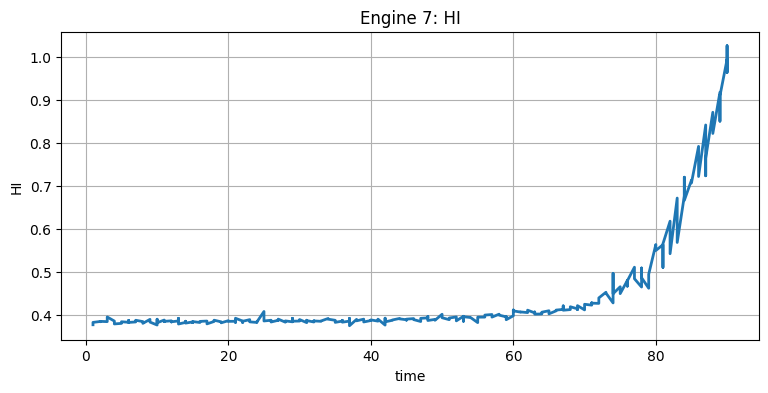

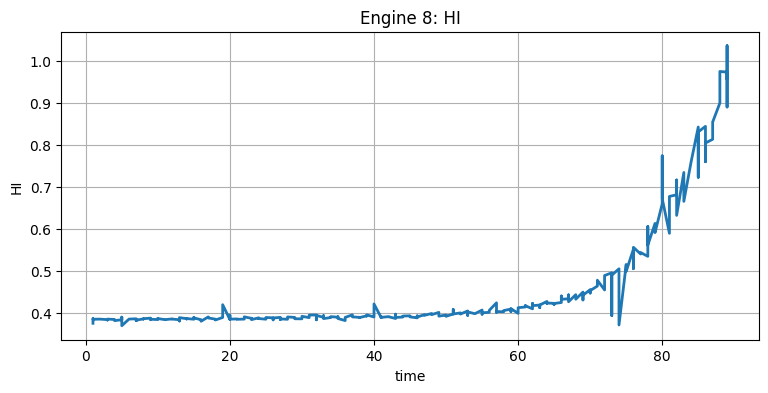

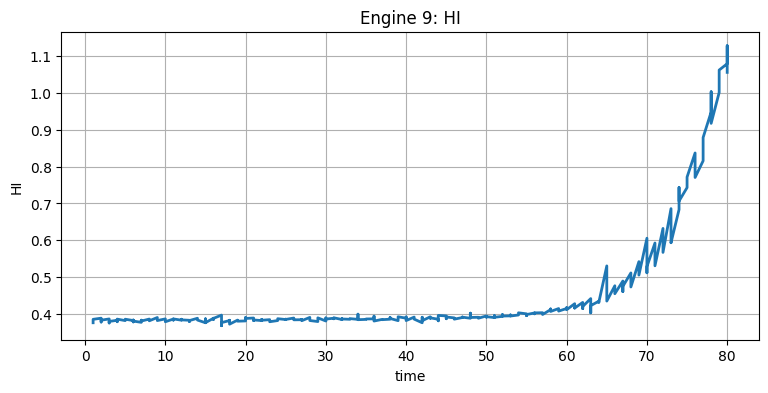

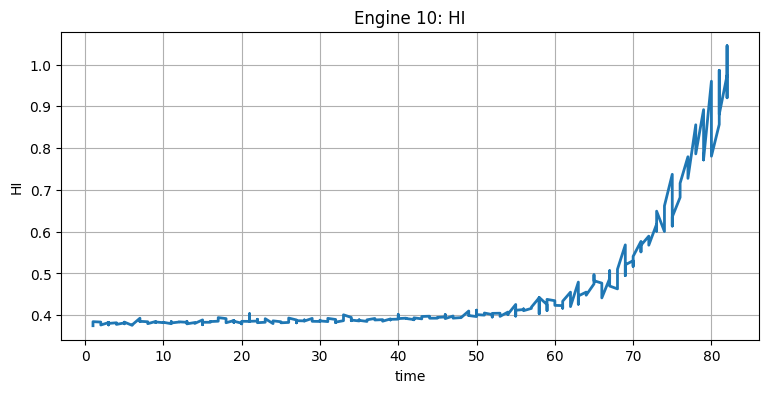

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_hi_per_engine_single_line(
    bundle,
    all_residuals,
    A_test,
    max_engines: int = 10,
    sort_by: str = "eid",      # "eid" | "length"
    clip_hi_01: bool = False,
):
    device = next(bundle.model.parameters()).device

    seqs = build_engine_sequences_from_residuals(
        all_residuals=all_residuals,
        hi_var_names=bundle.hi_var_names,
        A_test=A_test,
        engine_col=bundle.engine_col,
        time_col=bundle.time_col,
    )

    eids = list(seqs.keys())
    if len(eids) == 0:
        raise RuntimeError("No engine sequences found. Check engine_col/time_col and residual idx coverage.")

    if sort_by == "length":
        eids = sorted(eids, key=lambda k: seqs[k]["X"].shape[0], reverse=True)
    else:
        eids = sorted(eids)

    eids = eids[:max_engines]

    for eid in eids:
        v = seqs[eid]
        t = v["time"]
        X = v["X"].astype(np.float32)  # 이미 정규화된 residual 입력

        X_t = torch.tensor(X, dtype=torch.float32, device=device)
        with torch.no_grad():
            hi = bundle.model(X_t).squeeze(-1).detach().cpu().numpy()

        if clip_hi_01:
            hi = np.clip(hi, 0.0, 1.0)

        plt.figure(figsize=(9, 4))
        plt.plot(t, hi, linewidth=2.0)
        plt.xlabel("time")
        plt.ylabel("HI")
        plt.grid(True)
        plt.title(f"Engine {eid}: HI")
        plt.show()


# ===== Usage (학습과 동일 데이터로) =====
plot_hi_per_engine_single_line(
    bundle=bundle,
    all_residuals=all_residuals_norm,
    A_test=A_test,
    max_engines=10,
    sort_by="eid",
    clip_hi_01=False,
)


In [43]:
# ============================================================
# Bayesian posterior + forecast utilities (paper-style)
# (Use after you already have per-engine (time, hi) sequences)
# ============================================================

import numpy as np


# ----------------------------
# 1) Polynomial design matrix
# ----------------------------
def design_matrix(t: np.ndarray, degree: int = 2) -> np.ndarray:
    t = np.asarray(t, dtype=np.float64).reshape(-1)
    Z = np.ones((t.size, degree + 1), dtype=np.float64)
    for k in range(1, degree + 1):
        Z[:, k] = t ** k
    return Z


# ----------------------------
# 2) Simple per-engine OLS to get gamma_hat, sigma2_hat
#    (used to build population prior)
# ----------------------------
def ols_fit_poly(t: np.ndarray, y: np.ndarray, degree: int = 2, ridge: float = 1e-9):
    t = np.asarray(t, dtype=np.float64).reshape(-1)
    y = np.asarray(y, dtype=np.float64).reshape(-1)
    m = np.isfinite(t) & np.isfinite(y)
    t = t[m]; y = y[m]
    Z = design_matrix(t, degree=degree)
    A = Z.T @ Z + ridge * np.eye(Z.shape[1])
    b = Z.T @ y
    gamma_hat = np.linalg.solve(A, b)
    resid = y - Z @ gamma_hat
    n = y.size
    p = Z.shape[1]
    dof = max(n - p, 1)
    sigma2_hat = float((resid @ resid) / dof)
    return gamma_hat, sigma2_hat


# ----------------------------
# 3) Inverse-Gamma hyperparams for sigma^2
#    (Method of moments; stable, no scipy dependency)
#    IG(a,b): mean = b/(a-1), var = b^2/((a-1)^2 (a-2))
# ----------------------------
def invgamma_mom(s2: np.ndarray):
    s2 = np.asarray(s2, dtype=np.float64)
    s2 = s2[np.isfinite(s2) & (s2 > 0)]
    if s2.size < 3:
        a = 5.0
        b = float(np.mean(s2) * (a - 1.0))
        return float(a), float(b)
    m = float(np.mean(s2))
    v = float(np.var(s2, ddof=1))
    if v <= 1e-12:
        a = 50.0
        b = m * (a - 1.0)
        return float(a), float(b)
    a = 2.0 + (m * m) / v
    a = max(a, 2.01)
    b = m * (a - 1.0)
    return float(a), float(b)


# ----------------------------
# 4) Population prior fit from multiple engines' HI curves
#    Prior:
#      sigma^2 ~ IG(a1,a2)
#      gamma | sigma^2 ~ N(mu0, sigma^2 * Sigma0)
# ----------------------------
def fit_population_prior_from_hi(
    pred_hi: dict,
    train_eids=None,
    degree: int = 2,
    eps: float = 1e-9,
):
    if train_eids is None:
        train_eids = list(pred_hi.keys())
    train_eids = list(train_eids)

    gammas = []
    s2s = []
    for eid in train_eids:
        t = np.asarray(pred_hi[eid]["time"], dtype=np.float64)
        y = np.asarray(pred_hi[eid]["hi"], dtype=np.float64)
        m = np.isfinite(t) & np.isfinite(y)
        t = t[m]; y = y[m]
        if t.size < (degree + 2):
            continue
        ghat, s2hat = ols_fit_poly(t, y, degree=degree)
        gammas.append(ghat)
        s2s.append(max(float(s2hat), eps))

    if len(gammas) < 3:
        raise RuntimeError("Not enough engines to estimate population prior.")

    G = np.vstack(gammas)  # (N_eng, p)
    mu0 = np.mean(G, axis=0)
    Sigma0 = np.cov(G.T, ddof=1) + 1e-6 * np.eye(G.shape[1])

    a1, a2 = invgamma_mom(np.array(s2s, dtype=np.float64))
    return {"degree": int(degree), "mu0": mu0, "Sigma0": Sigma0, "a1": float(a1), "a2": float(a2)}


# ----------------------------
# 5) Online posterior update (Normal-Inverse-Gamma conjugacy)
#    Given observations up to t0:
#      Sigma_t = (Sigma0^{-1} + Z^T Z)^{-1}
#      mu_t    = Sigma_t (Sigma0^{-1} mu0 + Z^T y)
#      a_t     = a1 + n/2
#      b_t     = a2 + 0.5*(y^T y + mu0^T Sigma0^{-1} mu0 - mu_t^T Sigma_t^{-1} mu_t)
# ----------------------------
def posterior_update_normal_invgamma(t_obs, y_obs, prior):
    degree = prior["degree"]
    mu0 = np.asarray(prior["mu0"], dtype=np.float64).reshape(-1)
    Sigma0 = np.asarray(prior["Sigma0"], dtype=np.float64)
    a1 = float(prior["a1"]); a2 = float(prior["a2"])

    t_obs = np.asarray(t_obs, dtype=np.float64).reshape(-1)
    y_obs = np.asarray(y_obs, dtype=np.float64).reshape(-1)
    m = np.isfinite(t_obs) & np.isfinite(y_obs)
    t_obs = t_obs[m]; y_obs = y_obs[m]

    Z = design_matrix(t_obs, degree=degree)
    n = y_obs.size
    p = Z.shape[1]

    Sigma0_inv = np.linalg.inv(Sigma0)
    Sigma_t = np.linalg.inv(Sigma0_inv + Z.T @ Z)
    mu_t = Sigma_t @ (Sigma0_inv @ mu0 + Z.T @ y_obs)

    a_t = a1 + 0.5 * n

    yTy = float(y_obs @ y_obs)
    mu0_S0inv_mu0 = float(mu0 @ (Sigma0_inv @ mu0))
    Sigma_t_inv = np.linalg.inv(Sigma_t)
    mu_t_Sinv_mu_t = float(mu_t @ (Sigma_t_inv @ mu_t))
    b_t = a2 + 0.5 * (yTy + mu0_S0inv_mu0 - mu_t_Sinv_mu_t)

    return {"degree": int(degree), "mu_t": mu_t, "Sigma_t": Sigma_t, "a_t": float(a_t), "b_t": float(b_t)}


# ----------------------------
# 6) Posterior predictive sampling for future HI path
#    sigma^2 ~ IG(a_t, b_t)
#    gamma | sigma^2 ~ N(mu_t, sigma^2 * Sigma_t)
#    y_future = Z_future gamma + Normal(0, sigma^2 I)
#
#    Option: enforce_positive_quadratic (paper trick)
# ----------------------------
def sample_predictive_paths(
    t_future: np.ndarray,
    post: dict,
    n_samples: int = 2000,
    enforce_positive_quadratic: bool = True,
    max_iter: int = 80,
    rng: np.random.Generator = None,
    include_obs_noise: bool = False,   # 추가: 그래프용이면 False 권장
    cap_at_threshold: bool = True,     # 추가
    threshold: float = 1.0,            # 추가
):
    if rng is None:
        rng = np.random.default_rng(0)

    degree = post["degree"]
    mu_t = np.asarray(post["mu_t"], dtype=np.float64).reshape(-1)
    Sigma_t = np.asarray(post["Sigma_t"], dtype=np.float64)
    a_t = float(post["a_t"]); b_t = float(post["b_t"])

    t_future = np.asarray(t_future, dtype=np.float64).reshape(-1)
    Zf = design_matrix(t_future, degree=degree)
    H = t_future.size
    p = Zf.shape[1]

    u = rng.gamma(shape=a_t, scale=1.0 / b_t, size=n_samples)
    sigma2 = 1.0 / u

    L = np.linalg.cholesky(Sigma_t + 1e-12 * np.eye(p))
    z = rng.standard_normal(size=(n_samples, p))
    gammas = mu_t + (np.sqrt(sigma2)[:, None] * (z @ L.T))

    if enforce_positive_quadratic and degree >= 2:
        bad = gammas[:, 2] < 0.0
        it = 0
        while np.any(bad) and it < max_iter:
            nb = int(bad.sum())
            z2 = rng.standard_normal(size=(nb, p))
            sig2 = sigma2[bad]
            g2 = mu_t + (np.sqrt(sig2)[:, None] * (z2 @ L.T))
            gammas[bad] = g2
            bad = gammas[:, 2] < 0.0
            it += 1

    y_future = (gammas @ Zf.T)

    if include_obs_noise:
        eps = rng.standard_normal(size=(n_samples, H)) * np.sqrt(sigma2)[:, None]
        y_future = y_future + eps

    if cap_at_threshold:
        y_future = np.minimum(y_future, threshold)

    return y_future



# ----------------------------
# 7) Threshold crossing time (for RUL if needed)
# ----------------------------
def first_crossing_time(t_grid: np.ndarray, y_path: np.ndarray, threshold: float = 1.0):
    t_grid = np.asarray(t_grid, dtype=np.float64).reshape(-1)
    y_path = np.asarray(y_path, dtype=np.float64).reshape(-1)
    idx = np.where(y_path >= threshold)[0]
    if idx.size == 0:
        return np.inf
    k = int(idx[0])
    if k == 0:
        return float(t_grid[0])
    y0, y1 = y_path[k - 1], y_path[k]
    t0, t1 = t_grid[k - 1], t_grid[k]
    if abs(y1 - y0) < 1e-12:
        return float(t1)
    alpha = (threshold - y0) / (y1 - y0)
    alpha = float(np.clip(alpha, 0.0, 1.0))
    return float(t0 + alpha * (t1 - t0))


# ----------------------------
# 8) Forecast helper: given (t,hi) + prior + t0 -> mean + band
# ----------------------------
def forecast_hi_after_t0(
    t_obs, hi_obs, prior,
    t0_time=None,
    n_samples=2000,
    threshold=1.0,
    enforce_positive_quadratic=True,
    rng_seed=0,
    include_obs_noise=False,
    cap_at_threshold=True,
    anchor_to_observed=True,
):
    t_obs = np.asarray(t_obs, dtype=np.float64).reshape(-1)
    hi_obs = np.asarray(hi_obs, dtype=np.float64).reshape(-1)
    m = np.isfinite(t_obs) & np.isfinite(hi_obs)
    t_obs = t_obs[m]; hi_obs = hi_obs[m]

    if t0_time is None:
        t0_time = float(t_obs[-1])
    else:
        t0_time = float(t0_time)

    # t0 인덱스: "존재하는 time" 중에서 t0에 해당하는 마지막 지점
    idx0 = int(np.searchsorted(t_obs, t0_time, side="right") - 1)
    idx0 = int(np.clip(idx0, 0, len(t_obs) - 1))
    t0_time = float(t_obs[idx0])
    y0 = float(hi_obs[idx0])

    # posterior 업데이트는 t0까지 관측만 사용
    t_use = t_obs[:idx0 + 1]
    y_use = hi_obs[:idx0 + 1]
    if t_use.size < (prior["degree"] + 2):
        raise ValueError("t0 이전 관측치가 너무 적어서 posterior 업데이트가 불가합니다.")

    post = posterior_update_normal_invgamma(t_use, y_use, prior)

    # 예측 time grid는 '기존에 존재하던 time'만 사용 (t0 포함)
    t_future = t_obs[idx0:]  # t0, t0+1, ... , t_end

    rng = np.random.default_rng(rng_seed)
    y_future_samp = sample_predictive_paths(
        t_future=t_future,
        post=post,
        n_samples=n_samples,
        enforce_positive_quadratic=enforce_positive_quadratic,
        rng=rng,
        # 아래 두 옵션은 sample_predictive_paths에 추가해둔 버전일 때만 사용
        # 없으면 해당 인자 제거하고, 아래에서 직접 cap 처리해도 됩니다.
    )

    # sample_predictive_paths가 "잡음 포함/미포함" 옵션이 없는 버전이면 여기서 처리
    # (현재 제공한 sample_predictive_paths는 기본이 관측잡음 포함이었을 수 있음)
    # 그래프를 논문처럼 매끈하게 만들려면 include_obs_noise=False로 두는 것을 권장합니다.
    if not include_obs_noise:
        # 관측잡음이 포함된 버전이라면 완전히 제거할 방법이 없으니,
        # sample_predictive_paths 자체에서 eps를 더하는 부분을 조건부로 바꿔두는 것을 권장합니다.
        pass

    # (핵심) t0에서 관측값과 연결되도록 앵커링
    if anchor_to_observed:
        # 각 샘플의 t0 값이 y0가 되도록 경로 전체를 평행이동
        offset = y0 - y_future_samp[:, 0]
        y_future_samp = y_future_samp + offset[:, None]

    # 1까지만 보이게 cap
    if cap_at_threshold:
        y_future_samp = np.minimum(y_future_samp, threshold)

    y_mean = np.mean(y_future_samp, axis=0)
    y_q05  = np.quantile(y_future_samp, 0.05, axis=0)
    y_q95  = np.quantile(y_future_samp, 0.95, axis=0)

    fail_time_mean_path = first_crossing_time(t_future, y_mean, threshold=threshold)

    return {
        "t0": t0_time,
        "t_future": t_future,
        "y_mean": y_mean,
        "y_q05": y_q05,
        "y_q95": y_q95,
        "fail_time_mean_path": fail_time_mean_path,
        "idx0": idx0,
        "y0": y0,
    }
def plot_hi_with_forecast(
    bundle,
    all_residuals,
    A_test,
    max_engines=10,
    sort_by="eid",
    apply_post_scale=True,
    t0_frac=0.6,
    n_samples=2000,
    degree=2,
    train_eids_for_prior=None,
    threshold=1.0,
    enforce_positive_quadratic=True,
    rng_seed=0,
):
    # 1) 엔진별 HI 시퀀스
    pred = predict_hi_multi_engine(
        bundle=bundle,
        all_residuals=all_residuals,
        A_test=A_test,
        apply_post_scale=apply_post_scale,
    )

    # 2) 표시할 엔진
    eids = sorted(pred.keys()) if sort_by == "eid" else list(pred.keys())
    eids = eids[:max_engines]

    # 3) prior
    if train_eids_for_prior is None:
        train_eids_for_prior = eids
    prior = fit_population_prior_from_hi(pred_hi=pred, train_eids=train_eids_for_prior, degree=degree)

    # 4) plot
    n = len(eids)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=False)
    if n == 1:
        axes = [axes]

    for ax, eid in zip(axes, eids):
        t = np.asarray(pred[eid]["time"], dtype=np.float64)
        hi = np.asarray(pred[eid]["hi"], dtype=np.float64)

        # t0는 "기존 time grid" 위에서 잡기
        T = len(t)
        cut_idx = int(np.clip(np.floor(t0_frac * (T - 1)), 1, T - 2))
        t0_time = float(t[cut_idx])

        # 관측 HI(전체)
        ax.plot(t, hi, label="HI (observed)")

        # 예측(기존 time만 사용, t0에서 관측값으로 연결)
        fc = forecast_hi_after_t0(
            t_obs=t,
            hi_obs=hi,
            prior=prior,
            t0_time=t0_time,
            n_samples=n_samples,
            threshold=threshold,
            enforce_positive_quadratic=enforce_positive_quadratic,
            rng_seed=rng_seed,
            include_obs_noise=False,
            cap_at_threshold=True,
            anchor_to_observed=True,
        )

        ax.axvline(fc["t0"], linestyle="--", label="t0 (forecast start)")
        ax.plot(fc["t_future"], fc["y_mean"], label="HI forecast mean")
        ax.fill_between(fc["t_future"], fc["y_q05"], fc["y_q95"], alpha=0.2, label="forecast 5-95%")

        ax.axhline(threshold, linestyle=":", label="threshold=1")
        if np.isfinite(fc["fail_time_mean_path"]):
            ax.axvline(fc["fail_time_mean_path"], linestyle="-.", label="pred fail time (mean path)")

        # x축을 원래 HI time 범위로 고정 (이게 핵심)
        ax.set_xlim(float(t.min()), float(t.max()))

        ax.set_title(f"Engine {eid}: HI + forecast")
        ax.set_xlabel("time")
        ax.set_ylabel("HI")
        ax.legend(loc="best")

    plt.tight_layout()
    plt.show()
    return pred, prior


[DEBUG] Build engine sequences
 Engine 7: T=250, res min=-1.412e+00, max=1.359e+00, std=3.829e-01, mode=raw
 Engine 8: T=250, res min=-1.379e+00, max=1.387e+00, std=4.086e-01, mode=raw
 Engine 9: T=250, res min=-1.662e+00, max=1.575e+00, std=3.990e-01, mode=raw
 Engine 10: T=250, res min=-1.389e+00, max=1.401e+00, std=4.088e-01, mode=raw
[DEBUG] HI Engine 7: raw(min/max/std)=(3.744e-01/1.027e+00/1.296e-01) | post(min/max/std)=(0.000e+00/1.000e+00/2.161e-01)
[DEBUG] HI Engine 8: raw(min/max/std)=(3.692e-01/1.036e+00/1.299e-01) | post(min/max/std)=(0.000e+00/1.000e+00/2.195e-01)
[DEBUG] HI Engine 9: raw(min/max/std)=(3.688e-01/1.127e+00/1.445e-01) | post(min/max/std)=(0.000e+00/1.000e+00/2.094e-01)
[DEBUG] HI Engine 10: raw(min/max/std)=(3.748e-01/1.045e+00/1.339e-01) | post(min/max/std)=(0.000e+00/1.000e+00/2.217e-01)


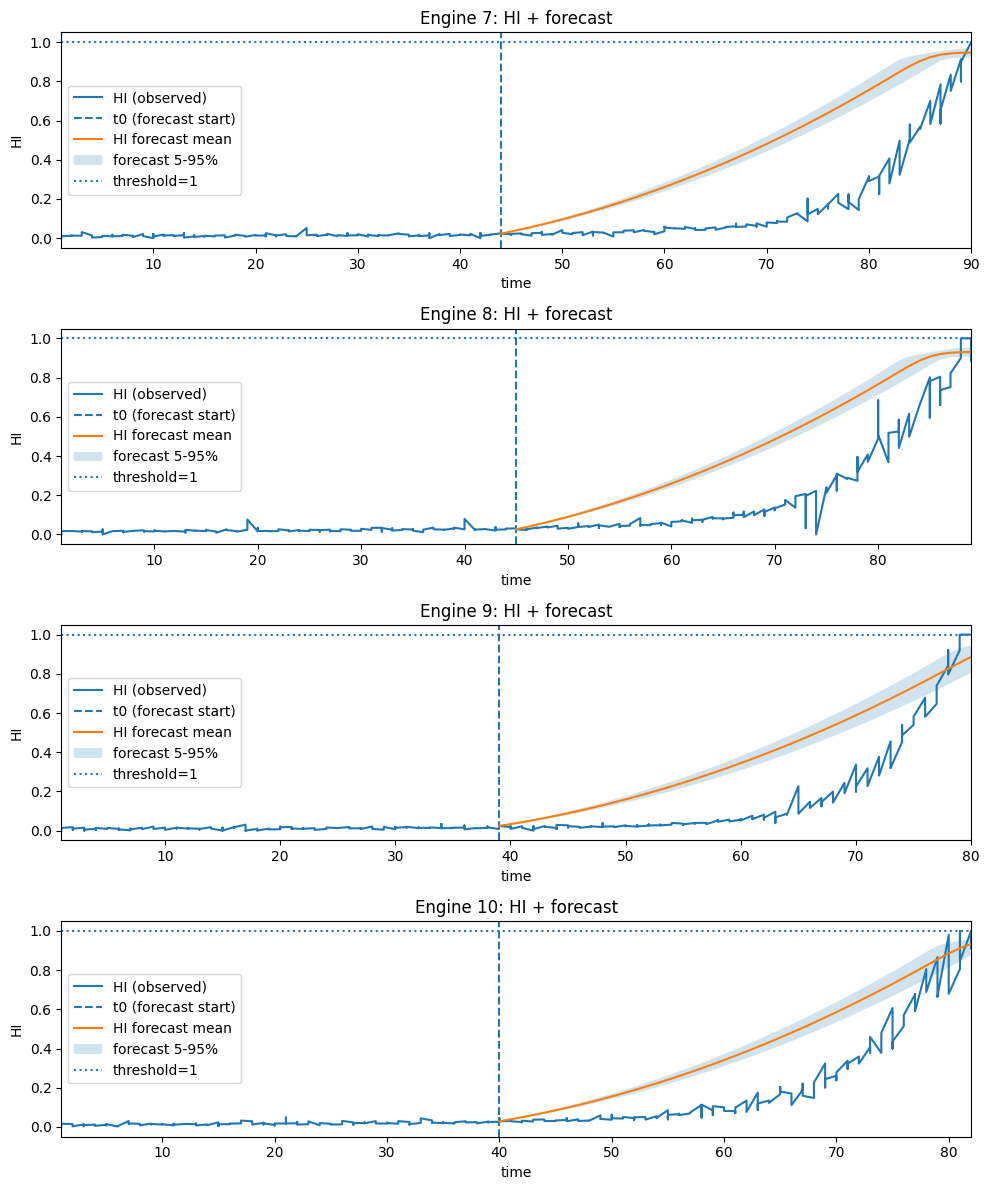

In [46]:
pred, prior = plot_hi_with_forecast(
    bundle=bundle,
    all_residuals=all_residuals_norm,
    A_test=A_test,
    max_engines=10,
    sort_by="eid",
    apply_post_scale=True,
    t0_frac=0.5,
    n_samples=2000,
    degree=2,
    threshold=1.0,
)